train autoencoder using 1DCNN roi finder

In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
#!{sys.executable} -m pip install tensorflow-gpu==2.4
#!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/bhawks/.conda/envs/dune-1dcnn/lib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
wireplane = "U"
path = 'processed_data/'
filenames = [path+f for f in listdir(path) if (isfile(join(path, f)) and wireplane in f)]
filenames

['processed_data/mean_U.npy',
 'processed_data/std_U.npy',
 'processed_data/x_test_U.npy',
 'processed_data/x_train_U.npy',
 'processed_data/y_test_AE_U.npy',
 'processed_data/y_test_ROI_U.npy',
 'processed_data/y_train_AE_U.npy',
 'processed_data/y_train_ROI_U.npy']

In [3]:
x_test = np.load(filenames[2])
x_train = np.load(filenames[3])
y_test = np.load(filenames[4])
y_train = np.load(filenames[6])

In [4]:
mean = x_train.mean()
std = x_train.std()
np.save("latest_models/mean_AE_"+wireplane+"_nu", mean)
np.save("latest_models/scale_AE_"+wireplane+"_nu", std)

In [5]:
x_train_scaled = (x_train-mean)/std
x_test_scaled = (x_test-mean)/std
y_train_scaled = (y_train-mean)/std
y_test_scaled = (y_test-mean)/std

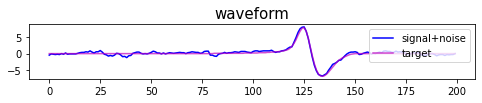

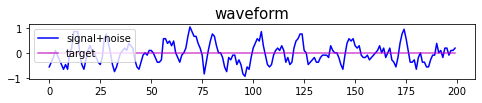

In [6]:
for idx in range(4,6):
    fig, (ax1) = plt.subplots(figsize=(8, 1), facecolor='white')
    ax1.plot(x_train_scaled[idx],color='blue', label='signal+noise')
    ax1.plot(y_train_scaled[idx],color='m',alpha=0.7, label='target')
    ax1.set_title("waveform", fontsize=15)
    ax1.legend()

    plt.show()

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense,Flatten, AveragePooling1D
from tensorflow.keras.layers import Input,  UpSampling1D
from tensorflow.keras.models import Model
#from keras import backend as K

In [8]:
from tensorflow.keras.models import load_model
model = load_model('latest_models/model_' + wireplane + 'plane_nu.h5')

In [9]:
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 conv1d
1 max_pooling1d
2 conv1d_1
3 max_pooling1d_1
4 dropout
5 conv1d_2
6 global_max_pooling1d
7 dropout_1
8 flatten
9 wavrec_out


In [10]:
time_periods = 200
input_wave = Input(shape=(x_train_scaled.shape[1], 1)) 
x = Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", weights=model.layers[0].get_weights() , input_shape=(time_periods,1))(input_wave)
x = MaxPooling1D(pool_size=2)(x)
 
#second convolutional block
x = Conv1D(filters=32, kernel_size=5, strides=2, weights=model.layers[2].get_weights(), activation = "relu", )(x)
x = MaxPooling1D(pool_size=2)(x)

encoded = Conv1D(filters=64, kernel_size=9, weights=model.layers[5].get_weights(), activation = "relu")(x)


x = Conv1D(filters=64, kernel_size=9, padding = "same", activation = "relu")(encoded)
x = UpSampling1D(4)(x)

x = Conv1D(filters=32, kernel_size=5, padding = "same", activation = "relu")(x)
x = UpSampling1D(3)(x)

x = Conv1D(filters=16, kernel_size=3,  activation = "relu")(x)
x = UpSampling1D(6)(x)

decoded = Conv1D(filters=1, kernel_size=5,  activation = "linear")(x)



autoencoder = Model(input_wave, decoded)

In [11]:
for i,layer in enumerate(autoencoder.layers):                                      
  print(i,layer.name)

0 input_1
1 conv1d
2 max_pooling1d
3 conv1d_1
4 max_pooling1d_1
5 conv1d_2
6 conv1d_3
7 up_sampling1d
8 conv1d_4
9 up_sampling1d_1
10 conv1d_5
11 up_sampling1d_2
12 conv1d_6


In [12]:
for layer in autoencoder.layers[:6]:                                               
    layer.trainable=False                                                          
for layer in autoencoder.layers[6:]:                                               
    layer.trainable=True                                                           
autoencoder.compile(optimizer='adam', loss='mse')

In [13]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             18496 

In [14]:
target = y_train_scaled

In [15]:
%%time
history = autoencoder.fit(x_train_scaled,                                                              
                    target,                                                            
                    batch_size=2048,                                              
                    epochs=100,                                                      
                    callbacks=None, # callbacks=callbacks_list,                         
                    validation_split=0.2, shuffle=False,                                               
                    verbose=1)   

Epoch 1/100
40/40 [==============================] - 3s 18ms/step - loss: 0.7146 - val_loss: 0.5782
Epoch 2/100
40/40 [==============================] - 0s 11ms/step - loss: 0.5338 - val_loss: 0.4589
Epoch 3/100
40/40 [==============================] - 0s 11ms/step - loss: 0.4275 - val_loss: 0.3716
Epoch 4/100
40/40 [==============================] - 0s 11ms/step - loss: 0.3534 - val_loss: 0.3131
Epoch 5/100
40/40 [==============================] - 0s 11ms/step - loss: 0.3061 - val_loss: 0.2754
Epoch 6/100
40/40 [==============================] - 0s 11ms/step - loss: 0.2723 - val_loss: 0.2503
Epoch 7/100
40/40 [==============================] - 0s 11ms/step - loss: 0.2479 - val_loss: 0.2266
Epoch 8/100
40/40 [==============================] - 0s 11ms/step - loss: 0.2257 - val_loss: 0.2091
Epoch 9/100
40/40 [==============================] - 0s 11ms/step - loss: 0.2103 - val_loss: 0.1964
Epoch 10/100
40/40 [==============================] - 0s 11ms/step - loss: 0.1965 - val_loss: 0.1847

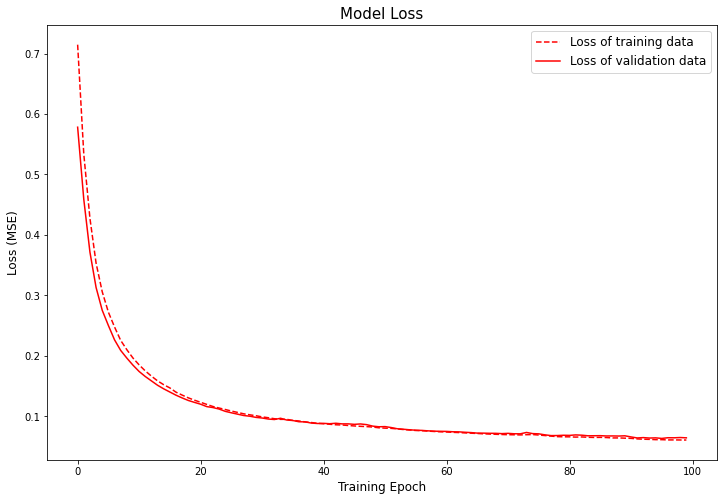

In [16]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['loss'], "r--", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "r", label="Loss of validation data", antialiased=True)
plt.title('Model Loss',fontsize=15)                                            
plt.ylabel('Loss (MSE)', fontsize=12)                                                 
plt.xlabel('Training Epoch', fontsize=12)                                                                                                                       
plt.legend(fontsize=12)                                                                    
plt.show()     

In [17]:
#del x_train

import gc
gc.collect()

8261

In [18]:
autoencoder.save("latest_models/model_AE_" + wireplane + "plane_nu.h5")

In [19]:
autoencoder.evaluate(x_test_scaled, y_test_scaled, batch_size=4096)

25/25 [==============================] - 0s 7ms/step - loss: 0.0672


0.06719174981117249

In [20]:
%%time
y = autoencoder.predict(x_test_scaled, batch_size=4096)

25/25 [==============================] - 0s 5ms/step
Wall time: 356 ms


In [21]:
y = y.reshape(y.shape[0], y.shape[1])
y = std*y + mean

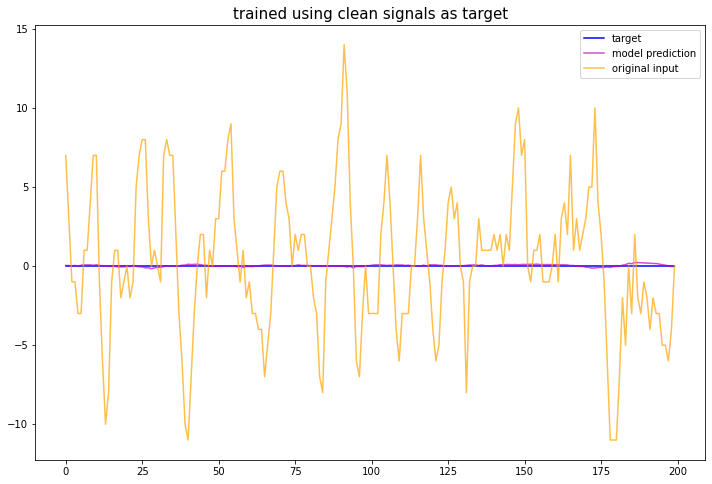

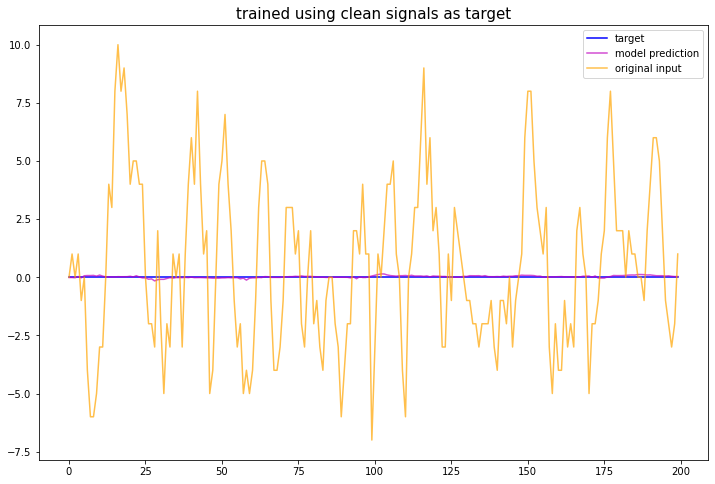

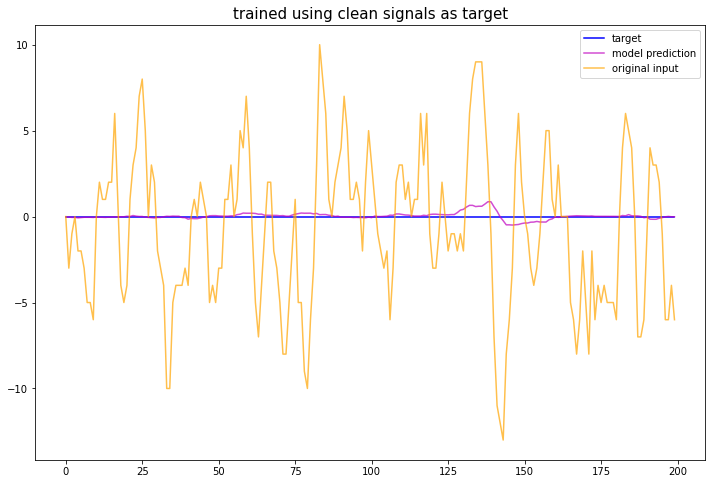

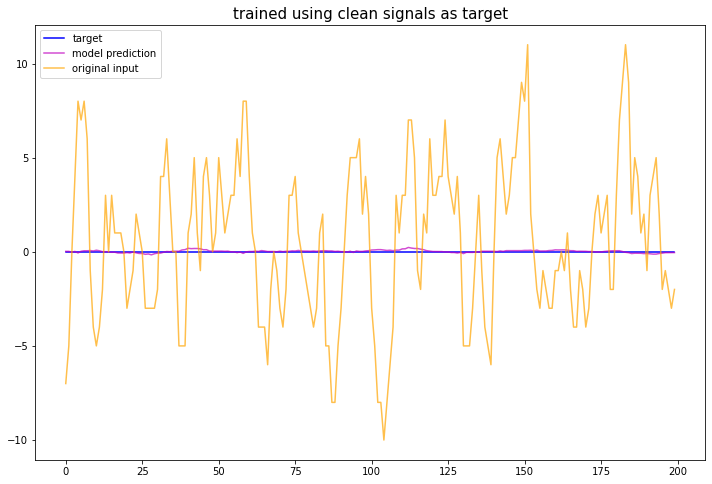

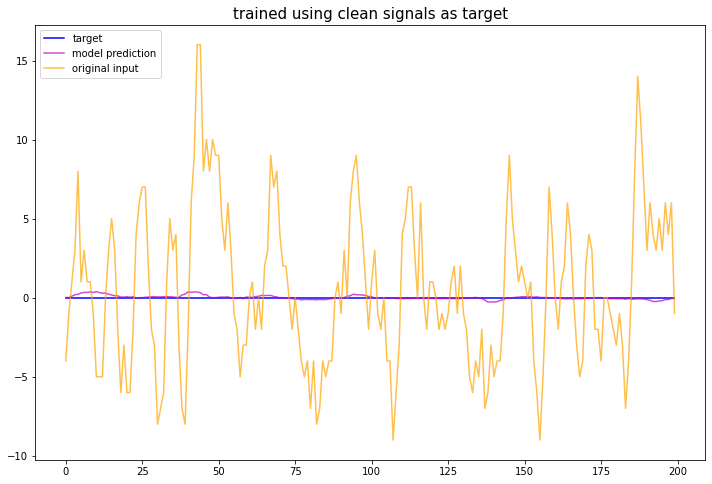

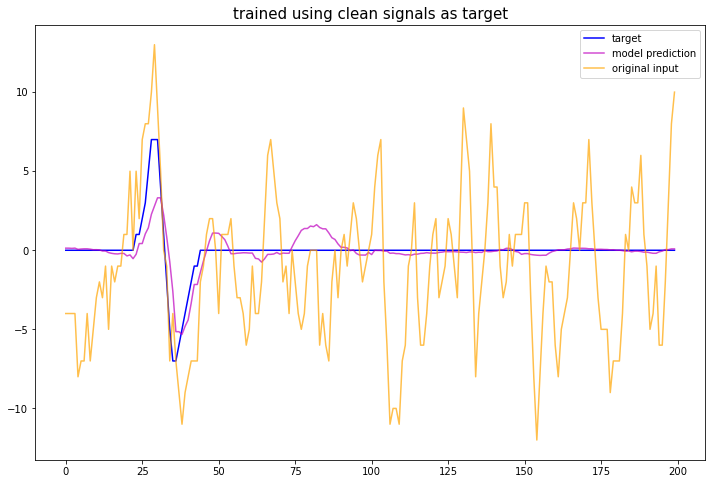

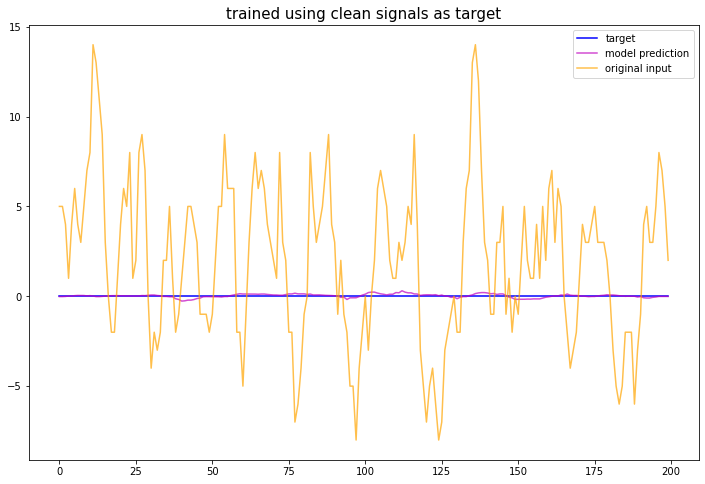

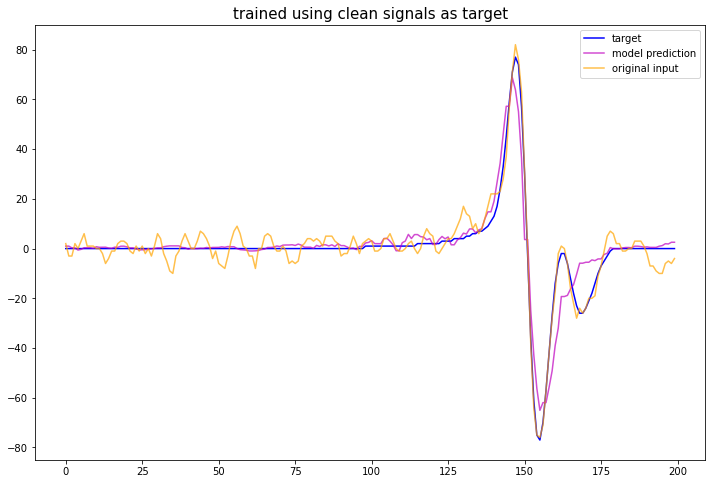

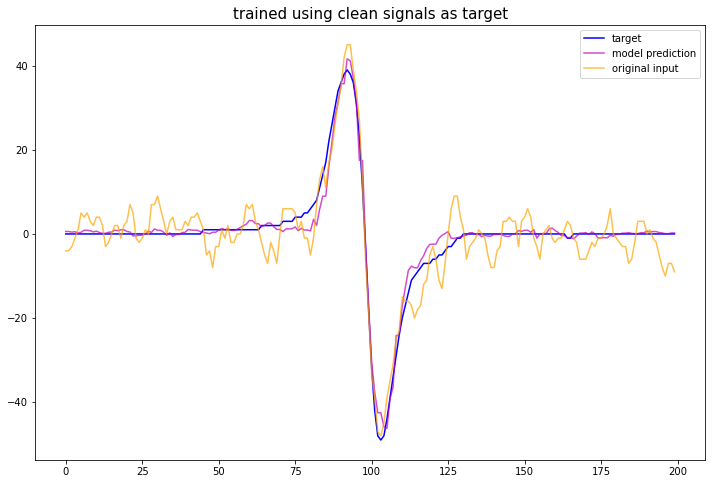

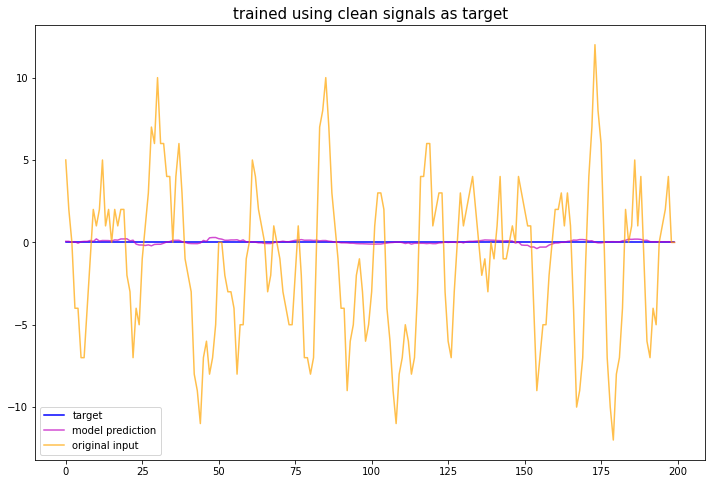

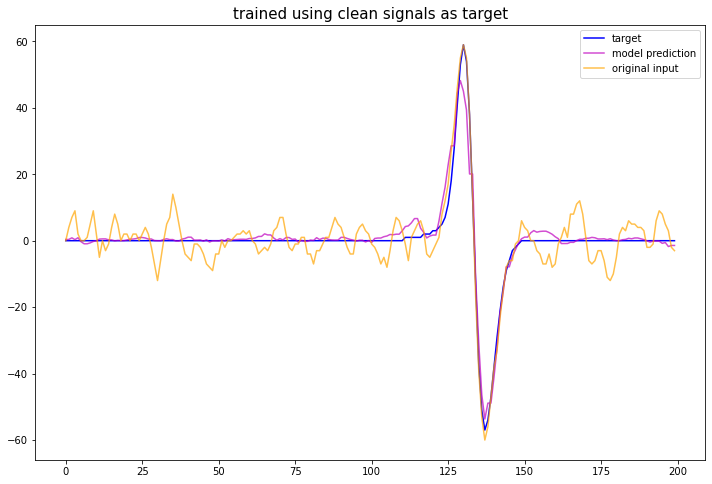

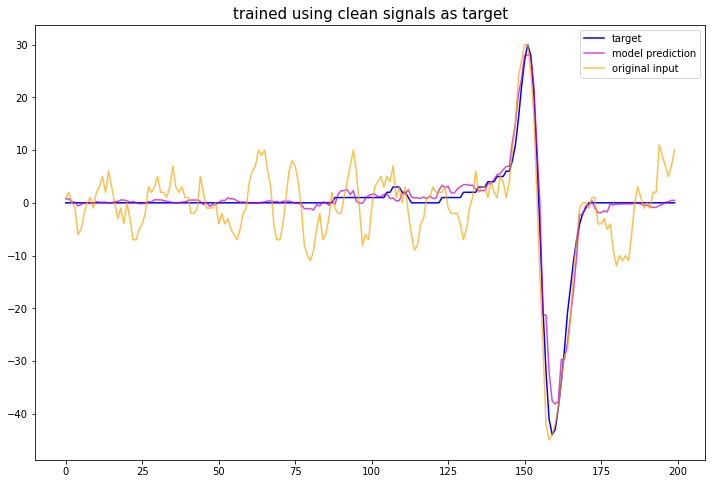

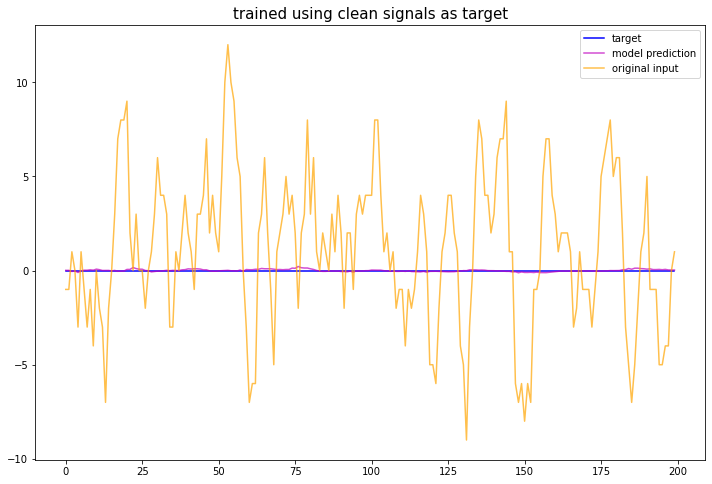

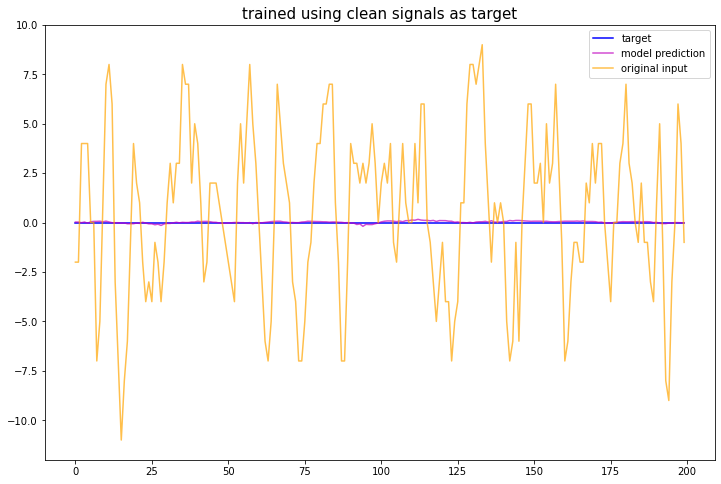

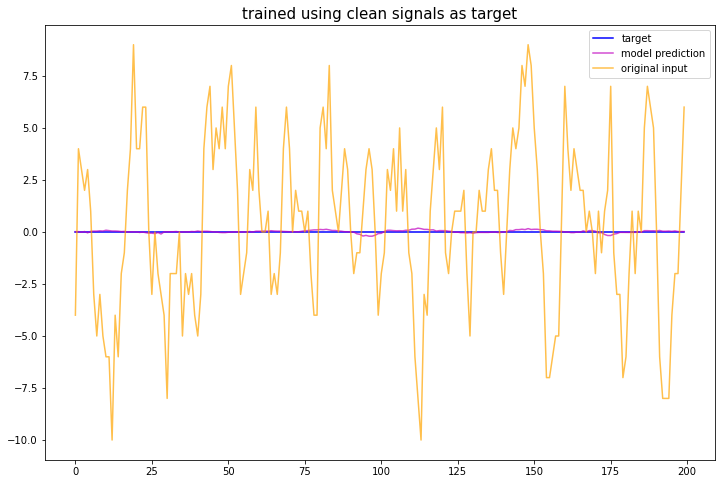

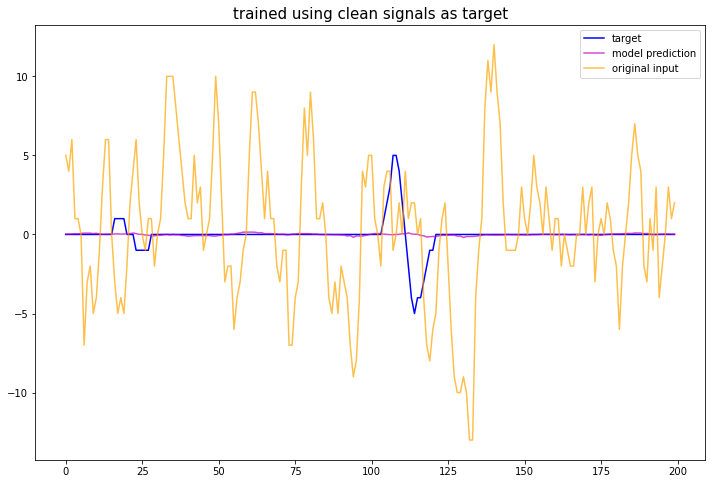

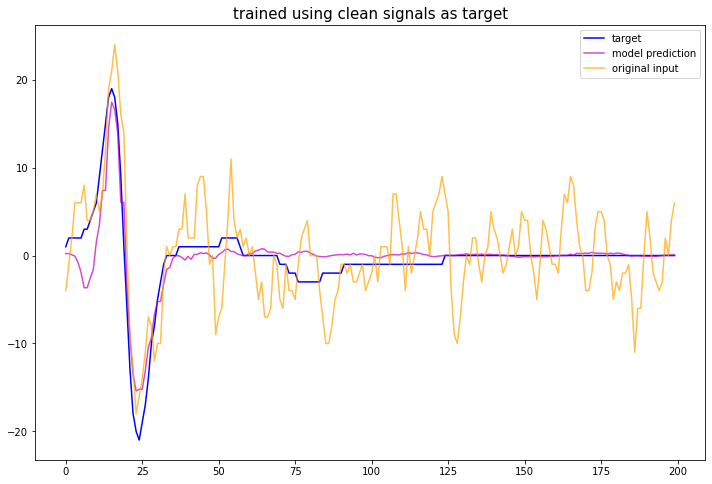

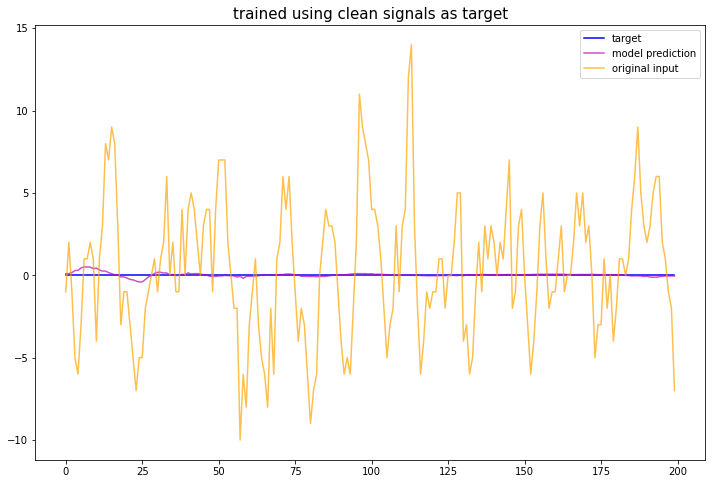

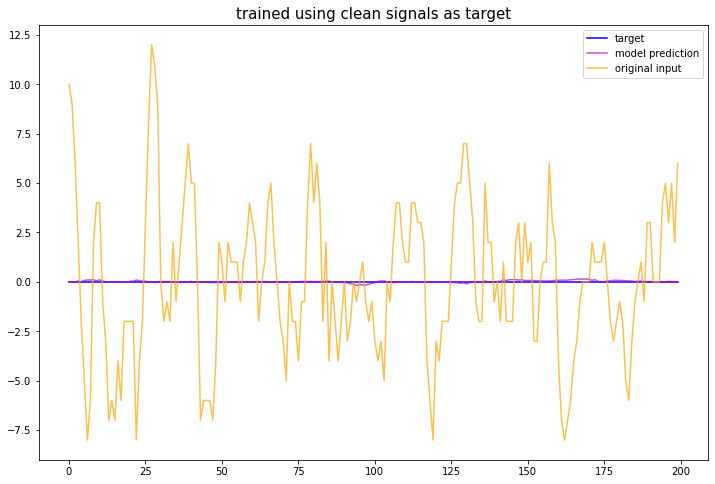

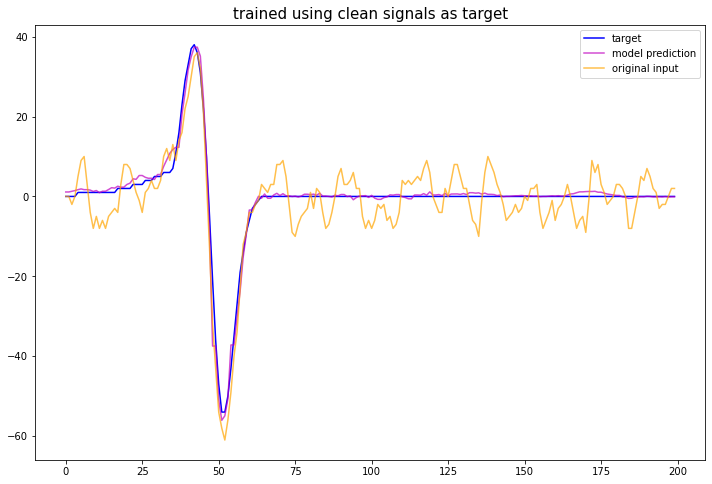

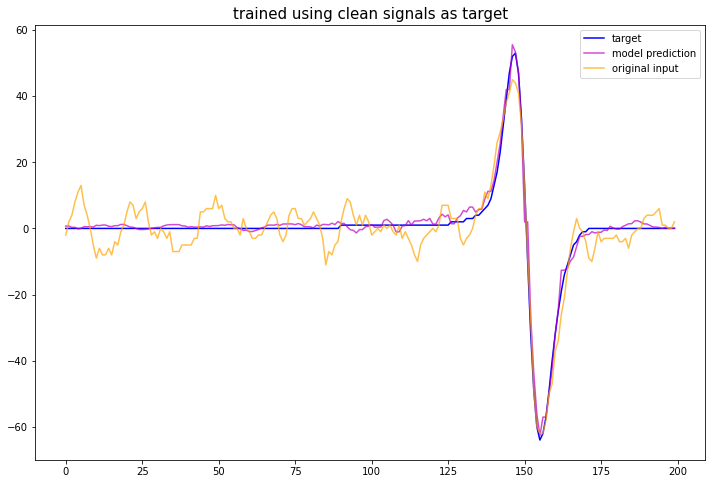

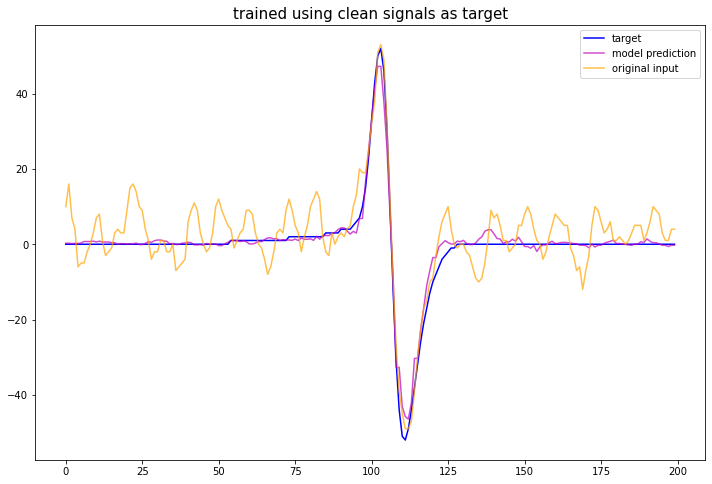

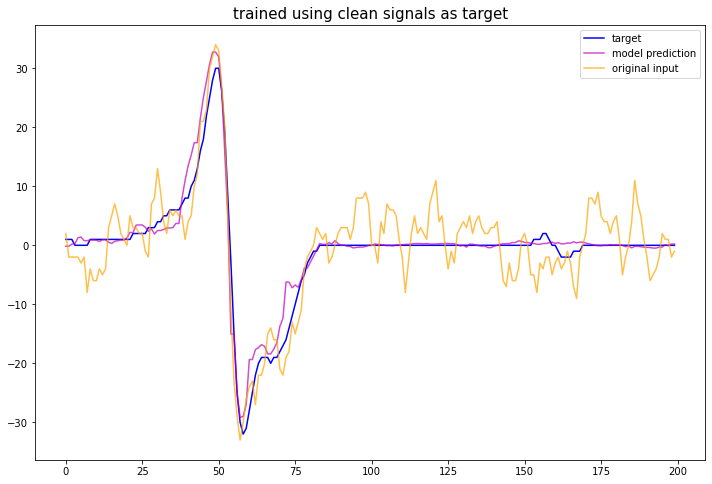

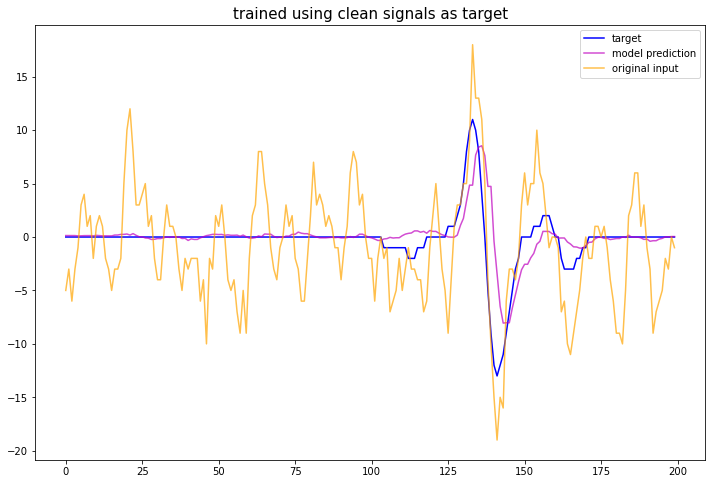

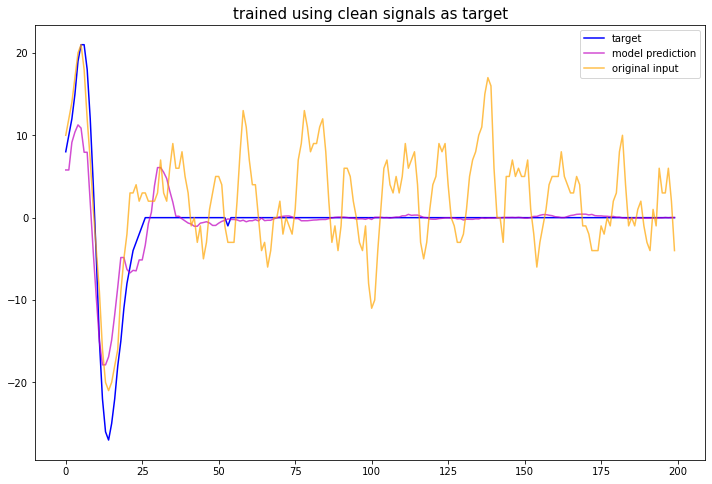

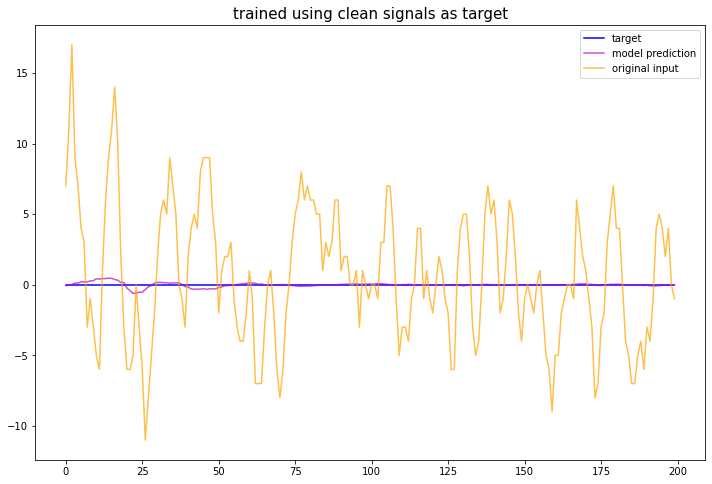

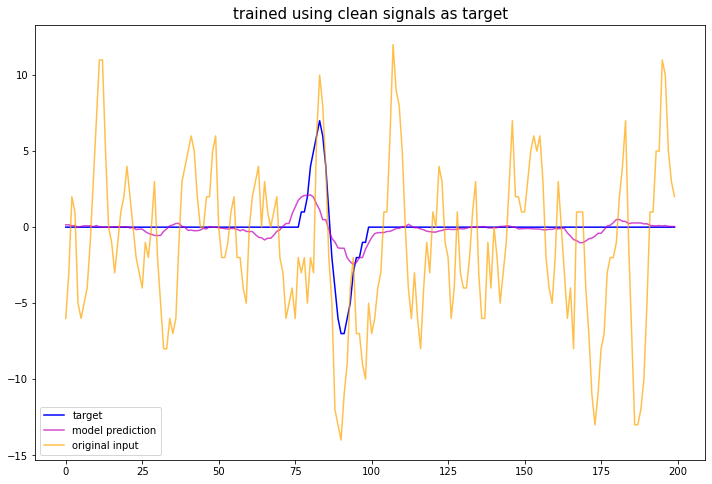

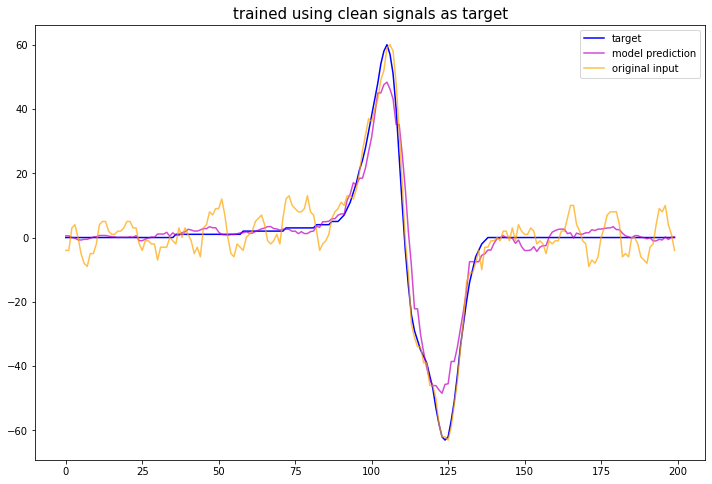

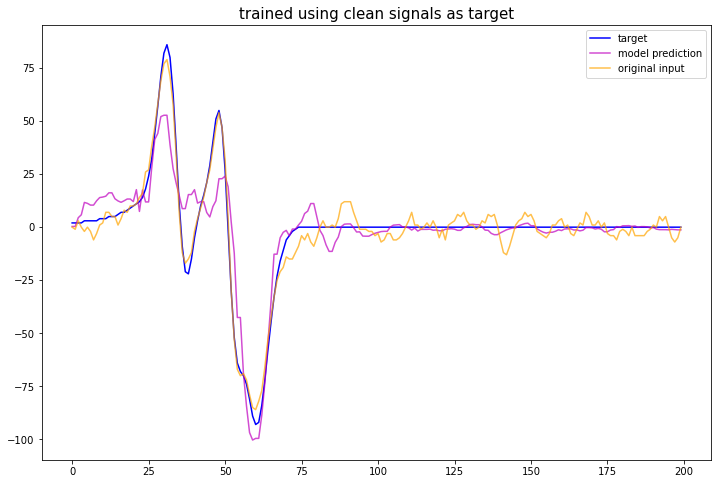

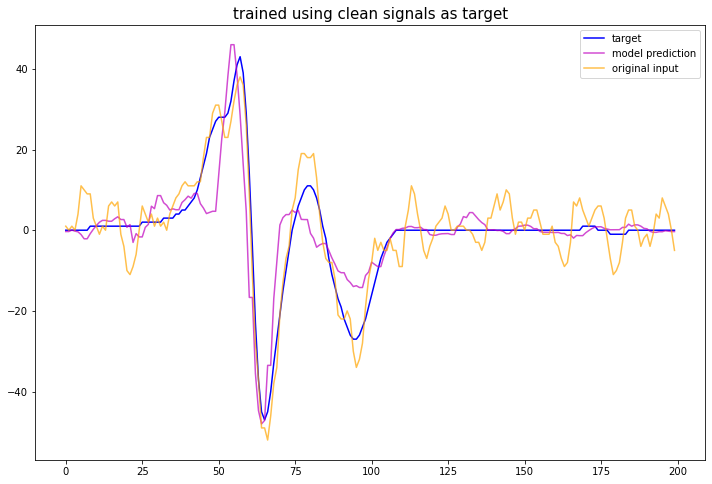

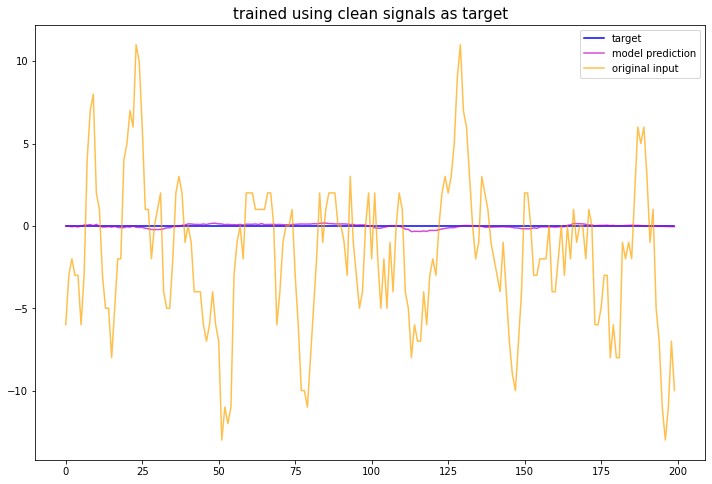

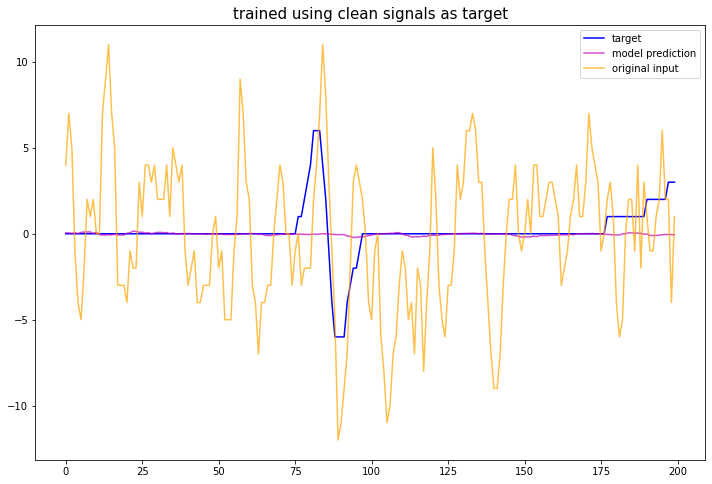

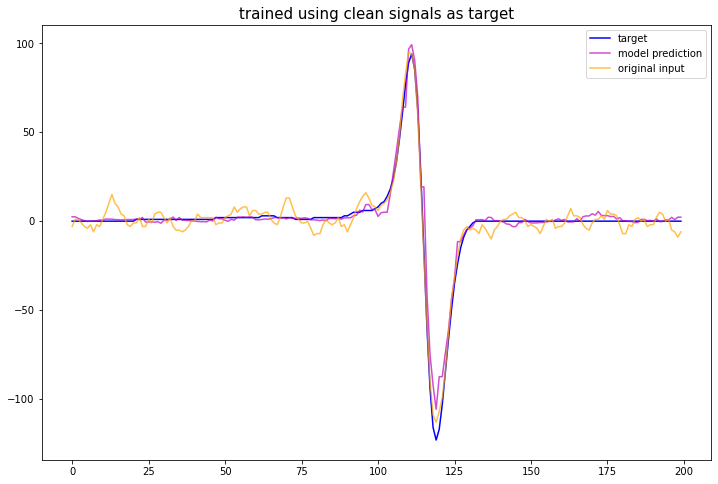

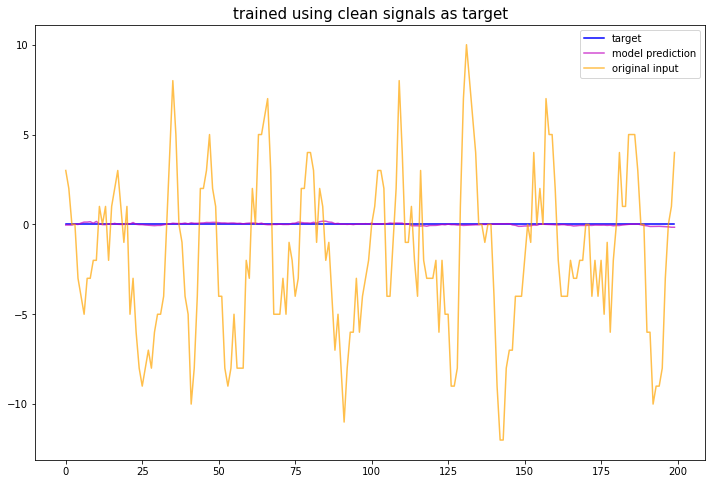

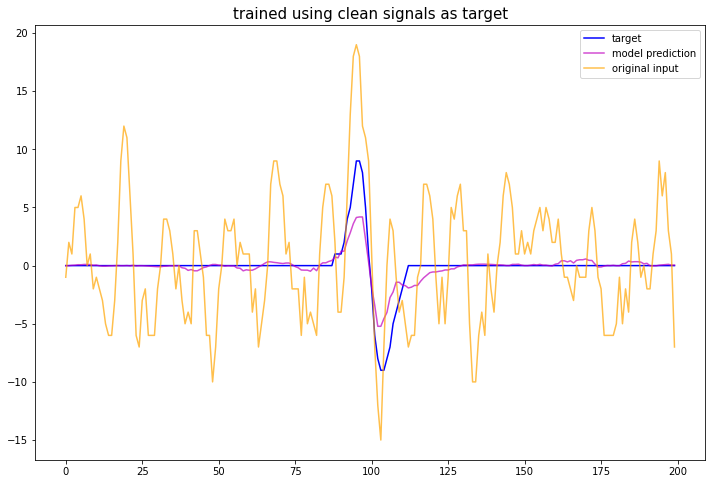

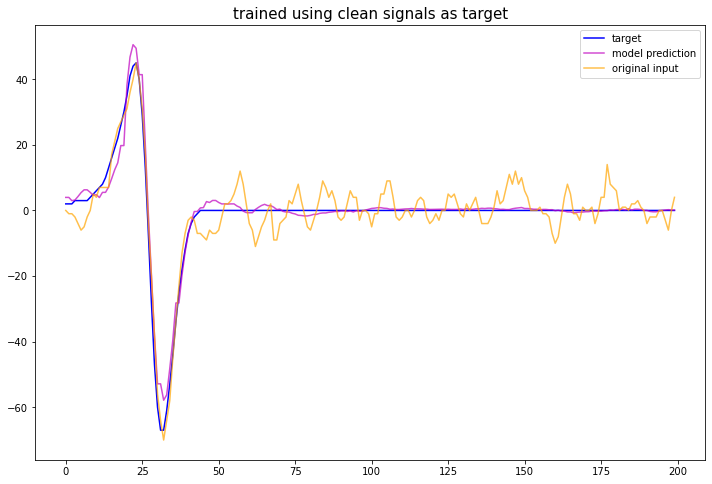

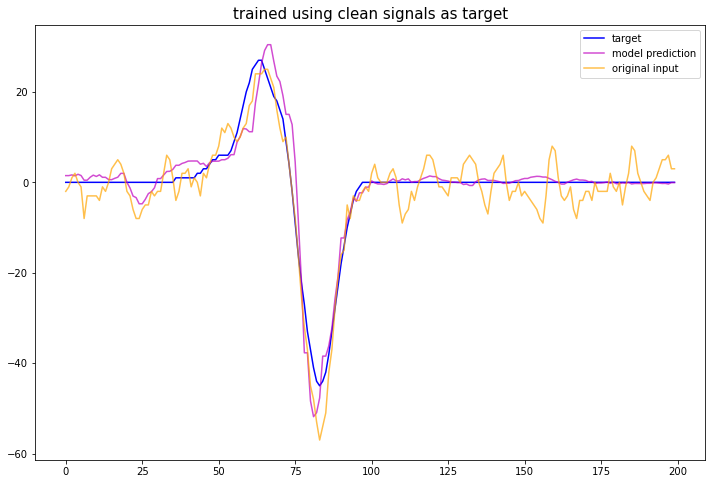

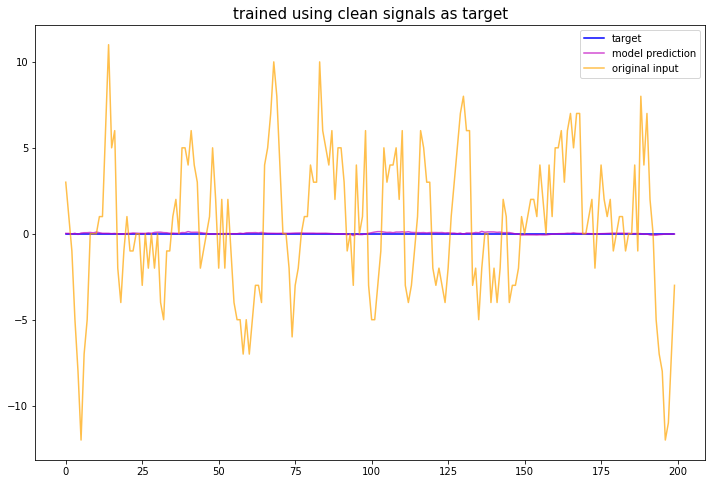

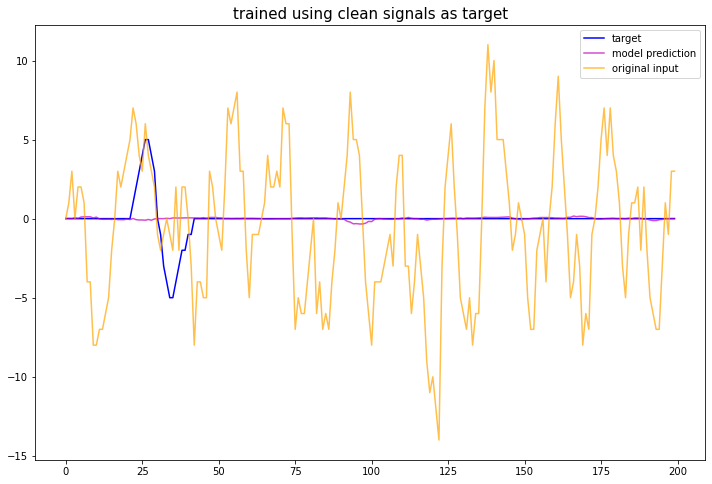

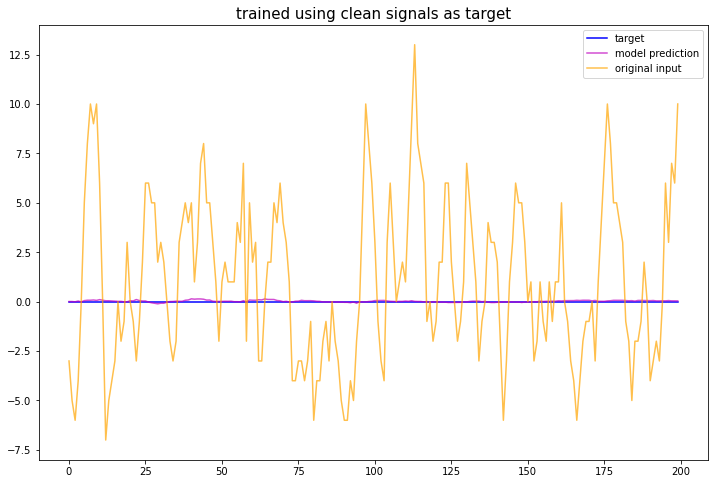

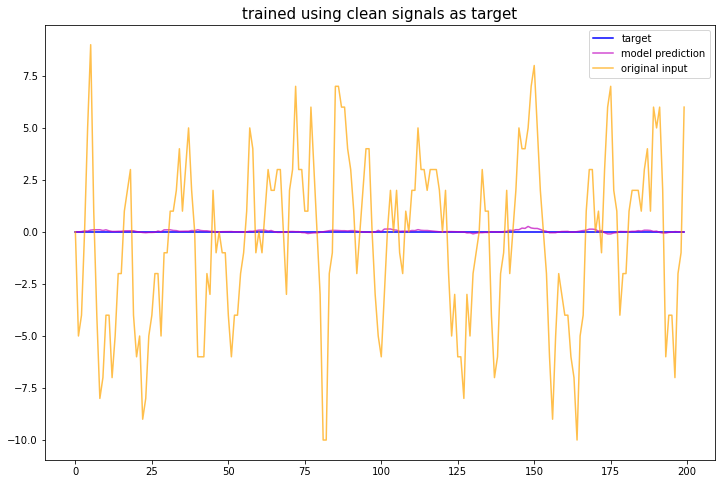

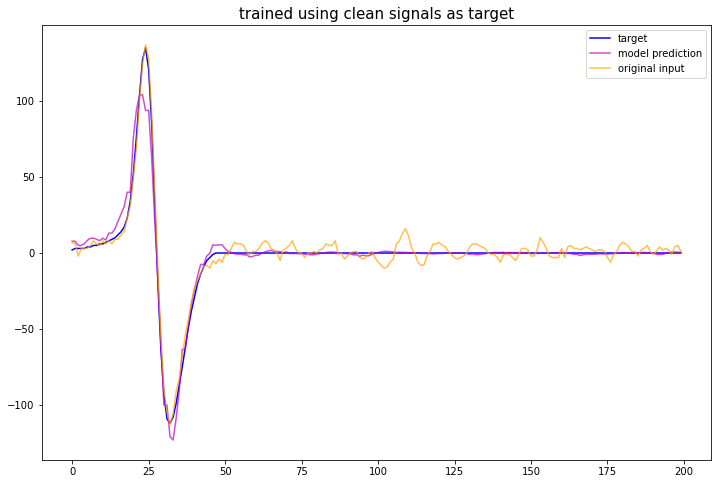

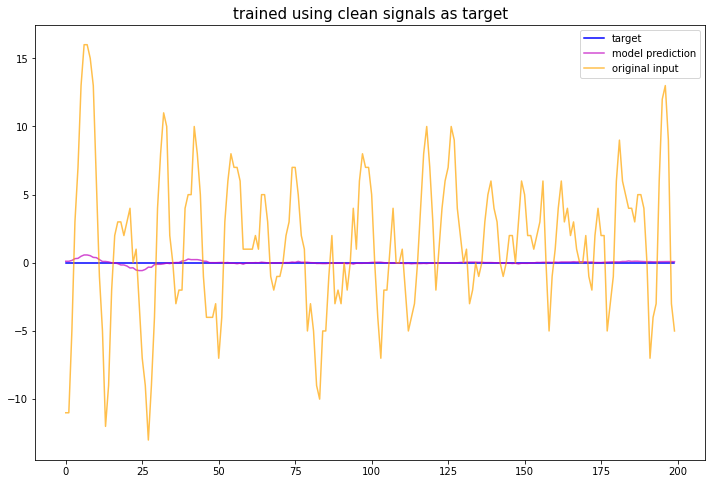

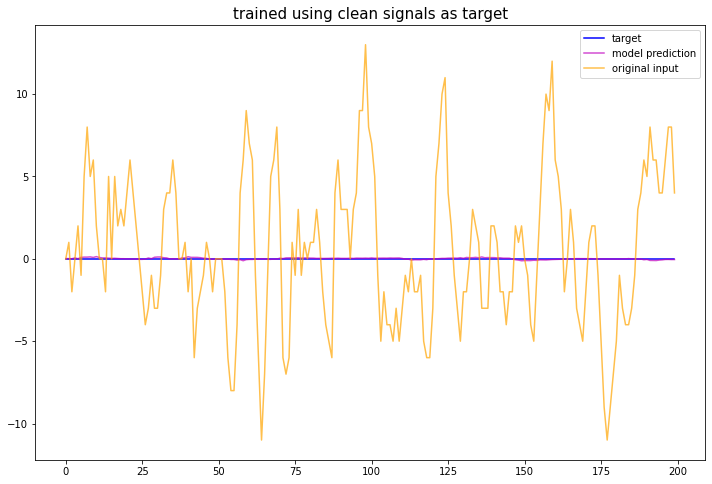

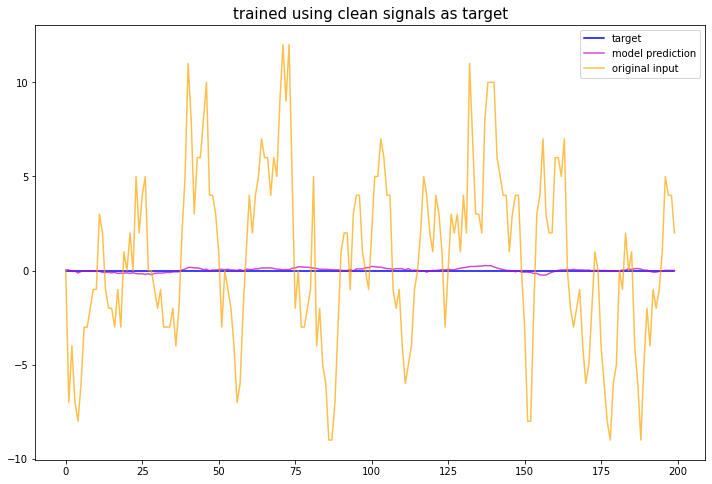

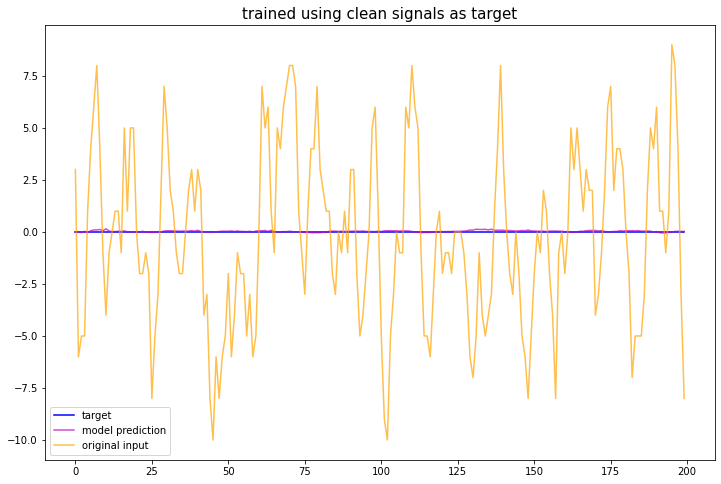

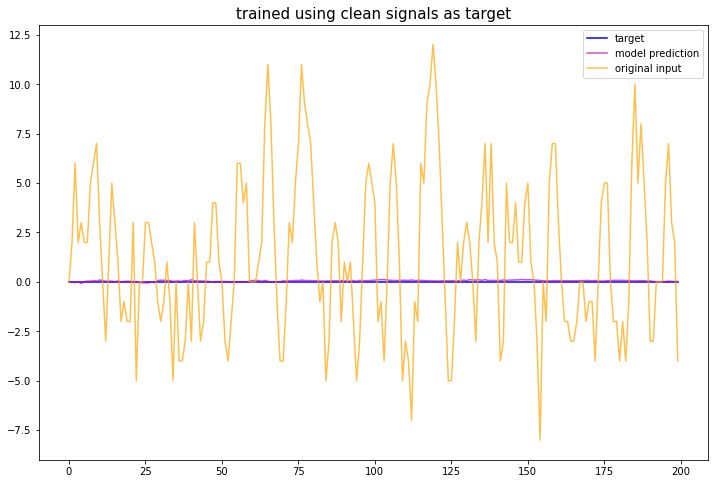

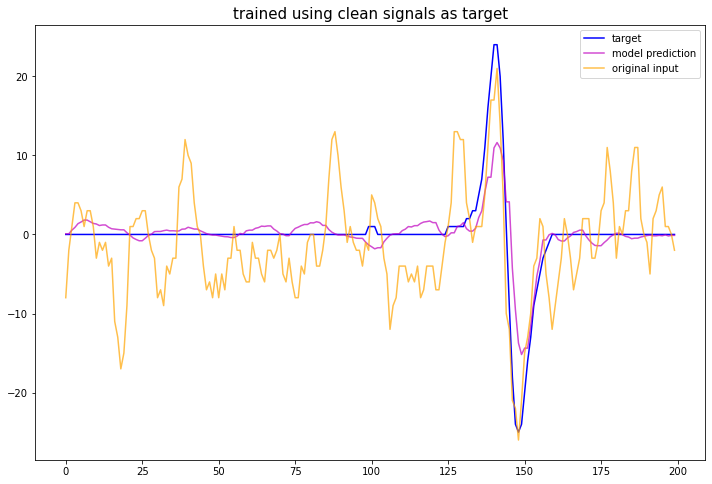

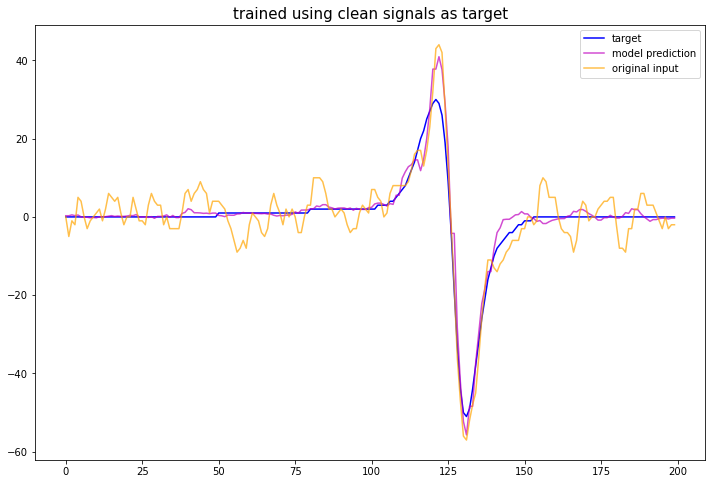

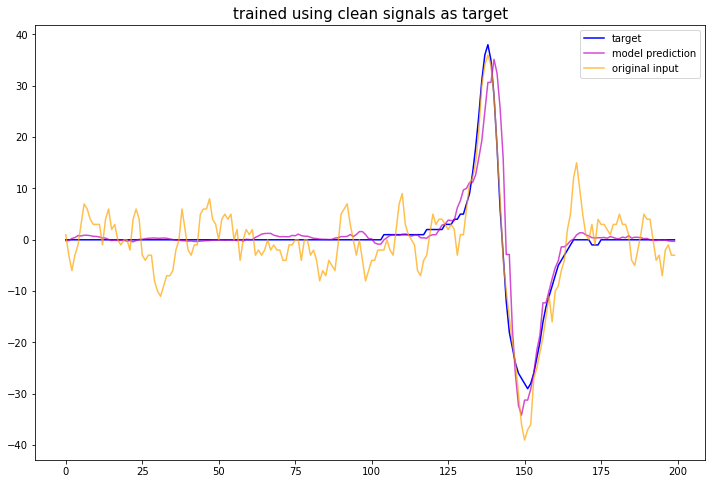

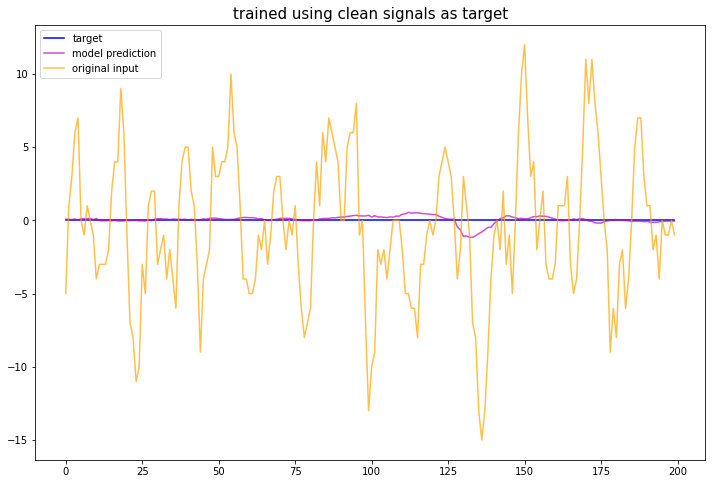

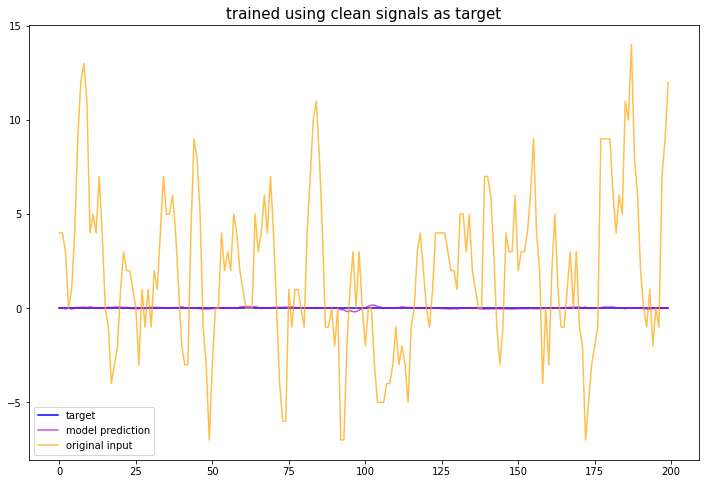

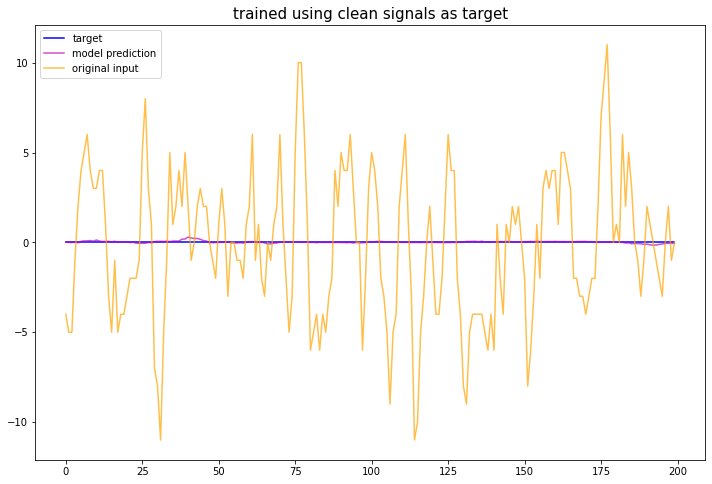

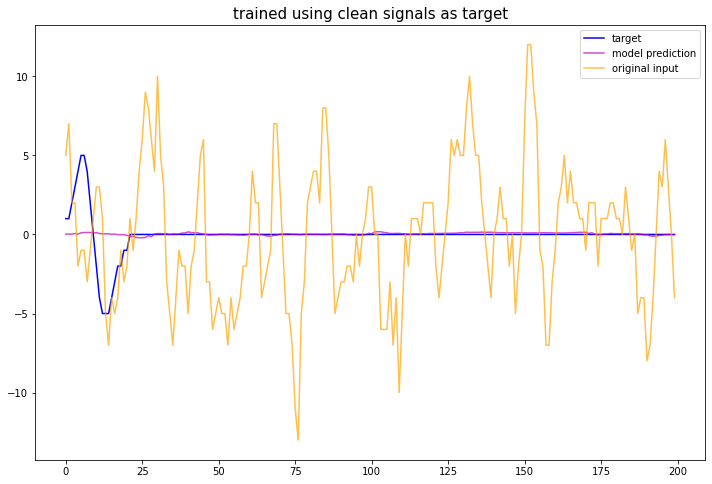

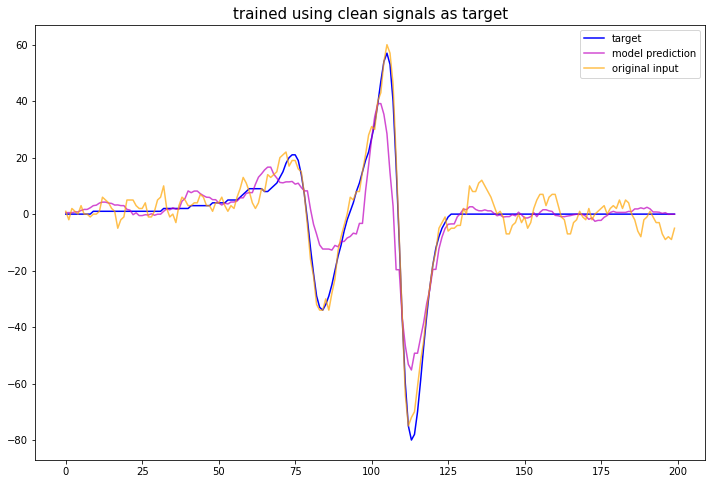

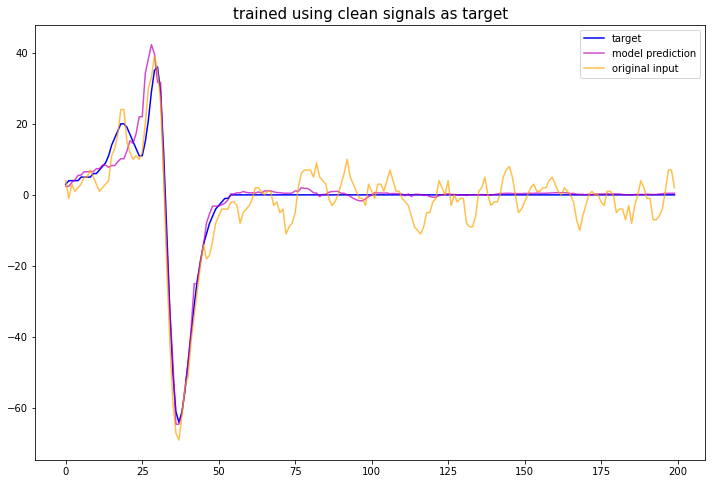

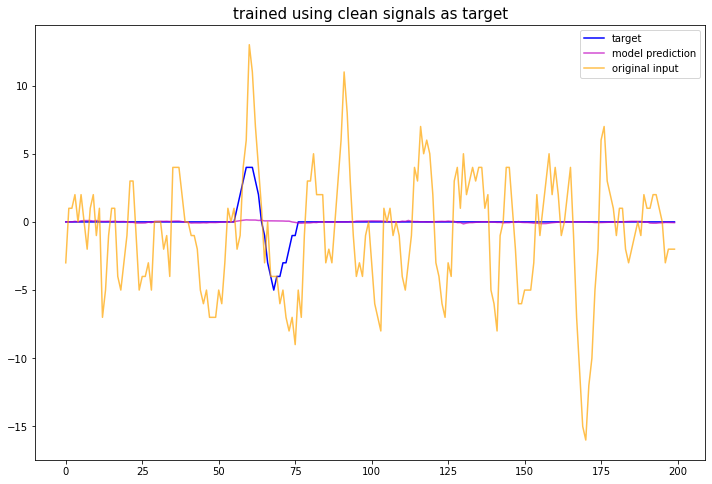

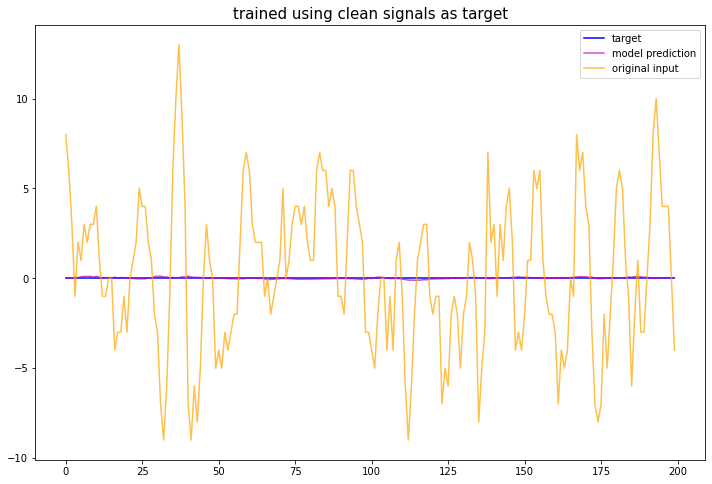

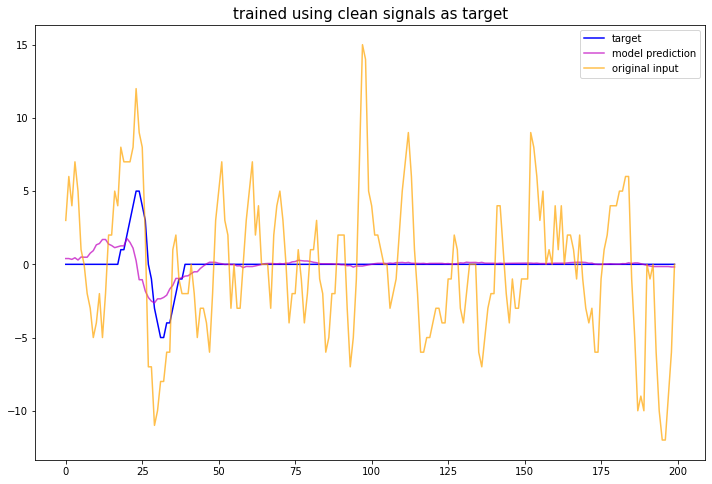

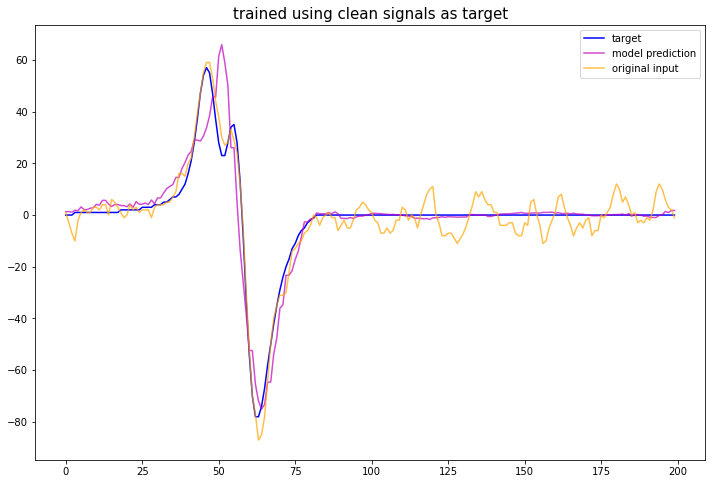

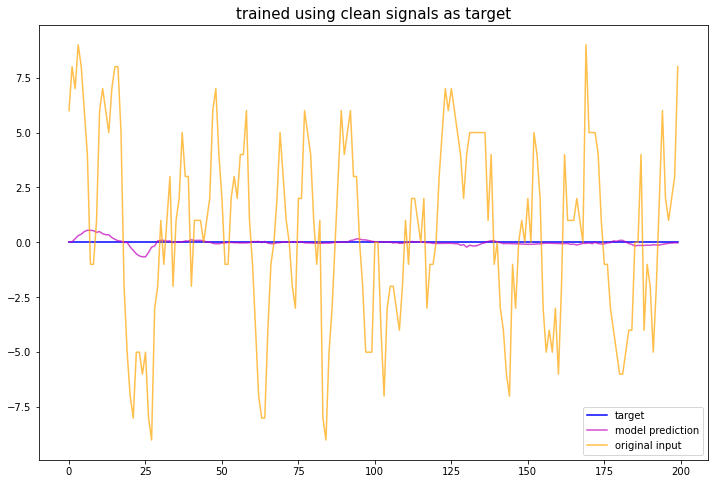

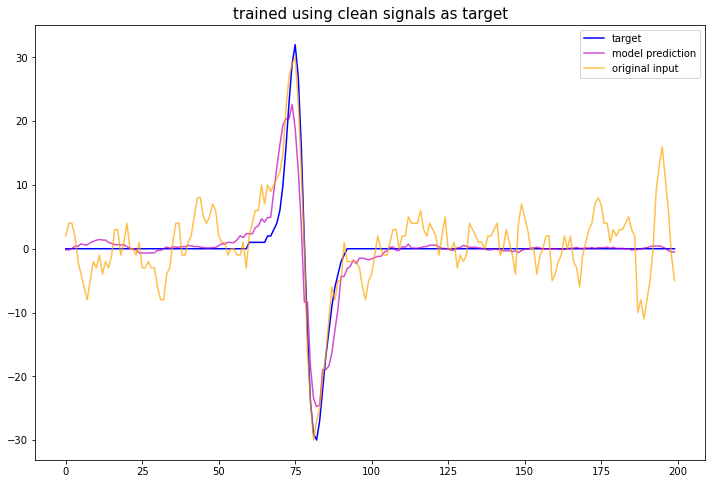

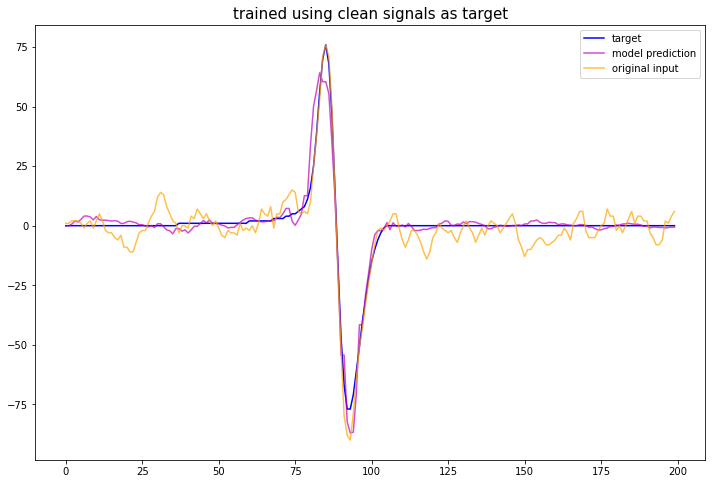

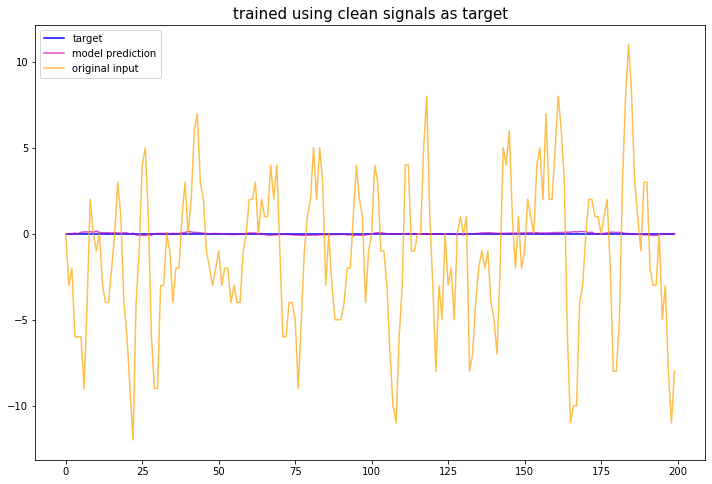

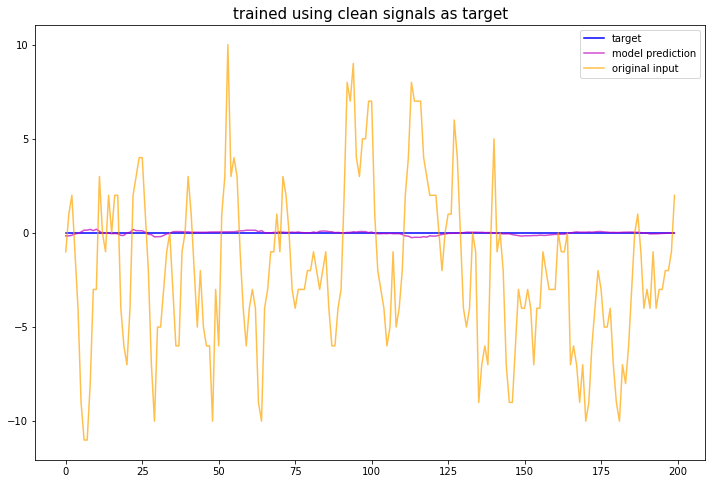

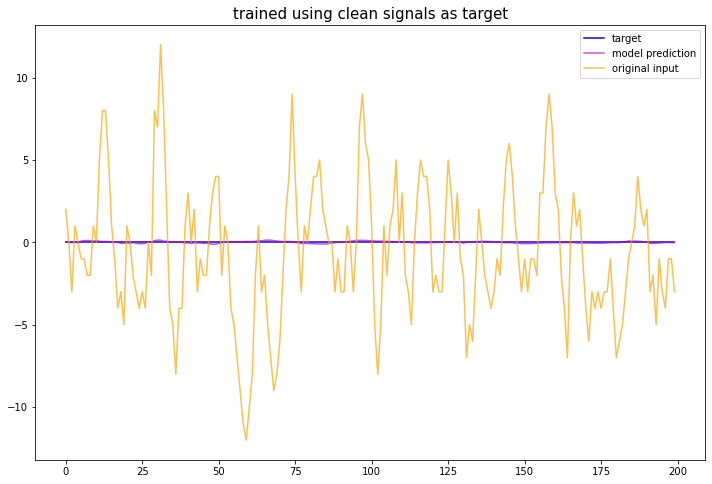

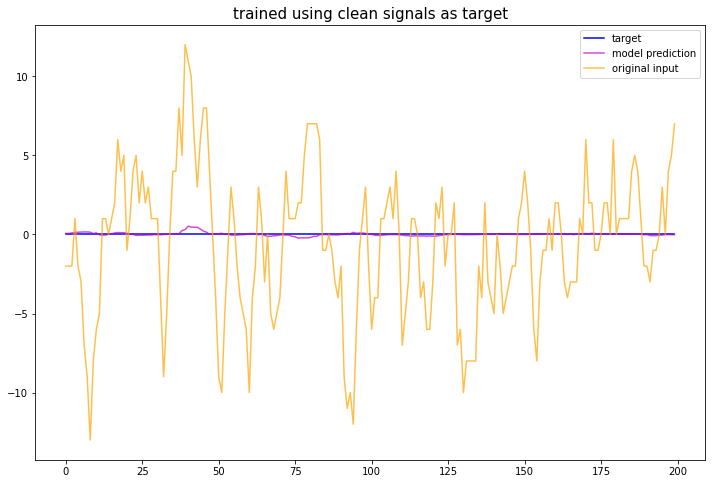

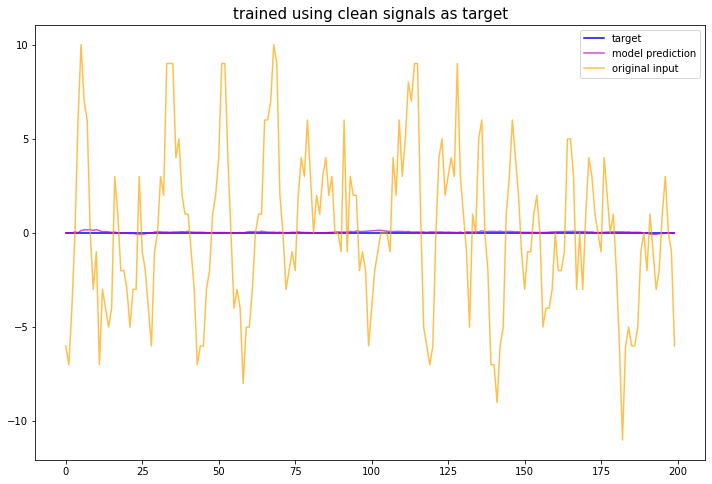

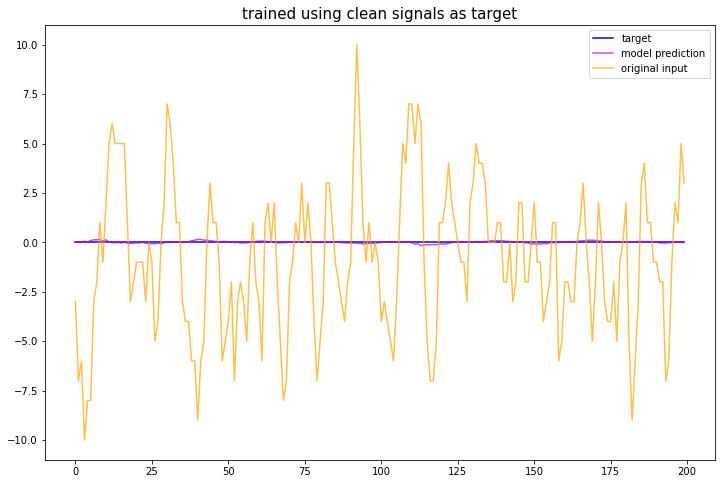

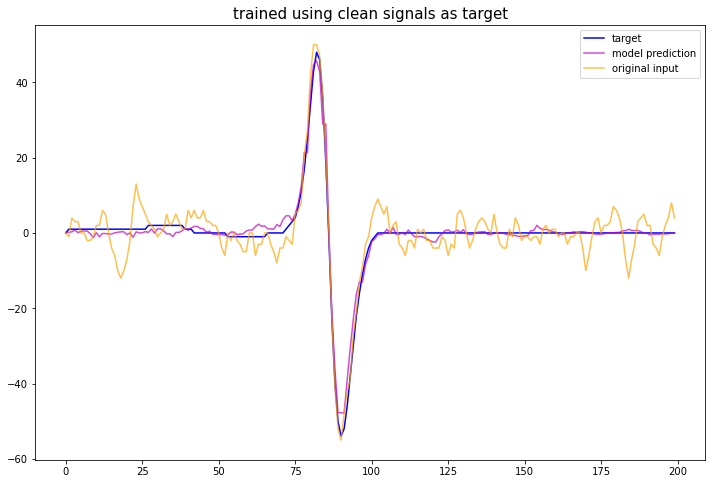

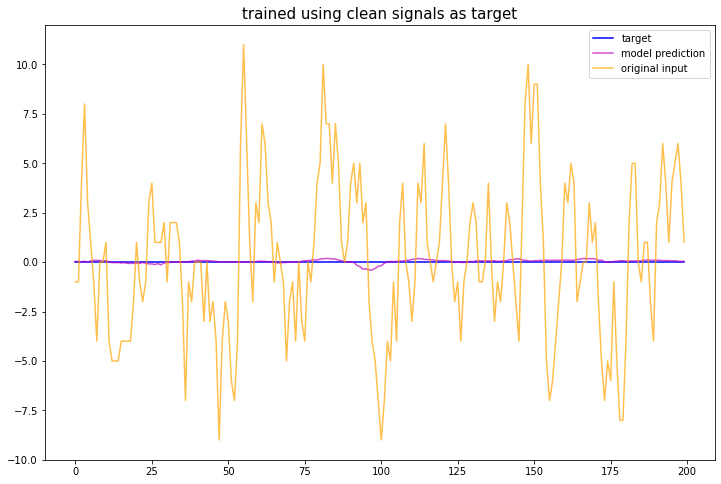

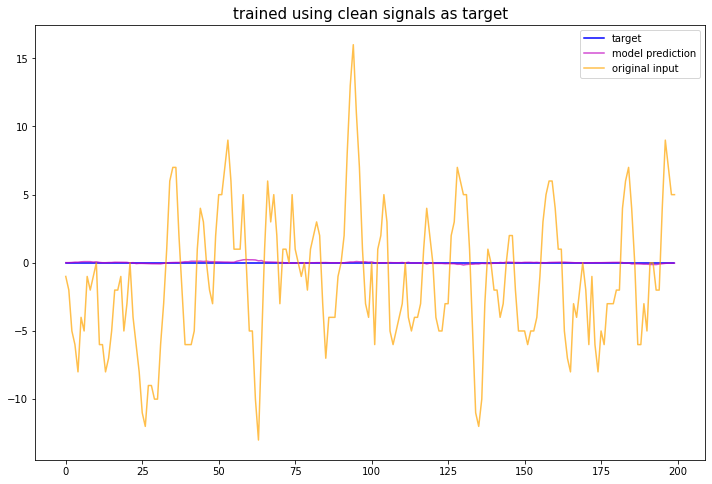

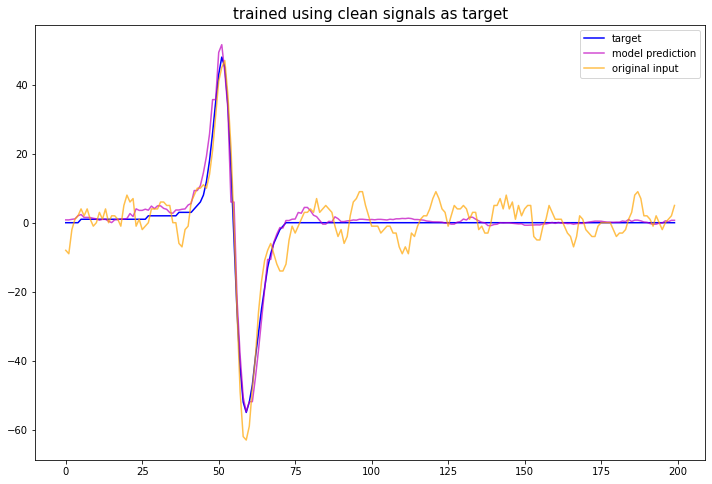

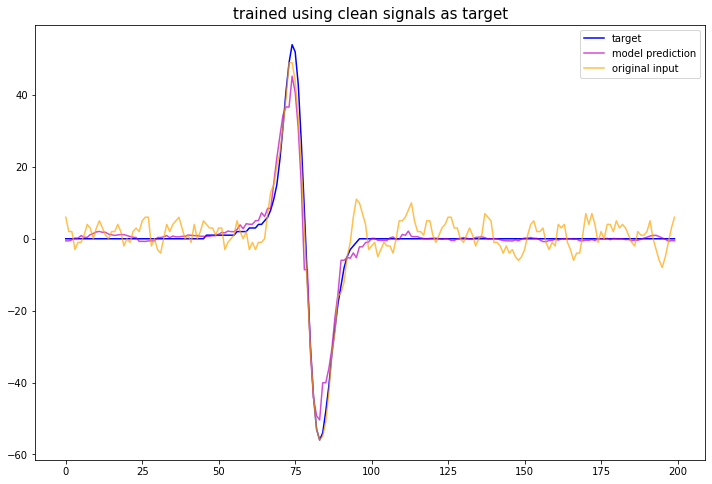

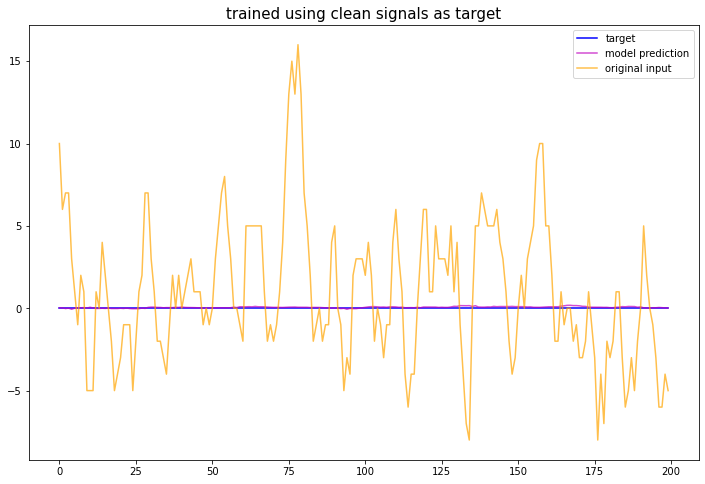

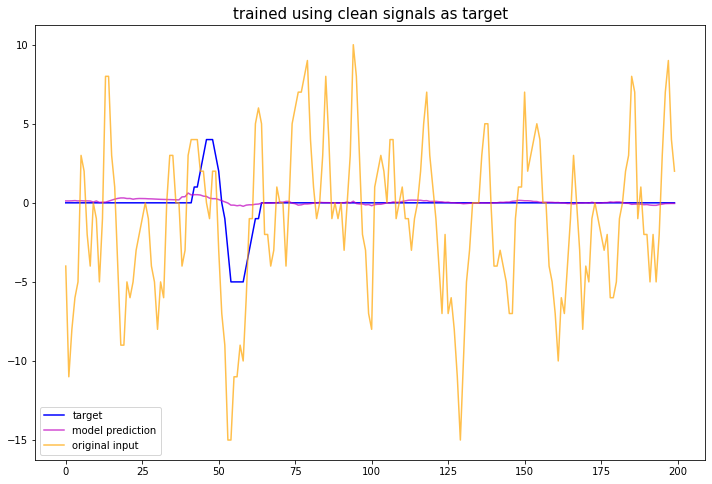

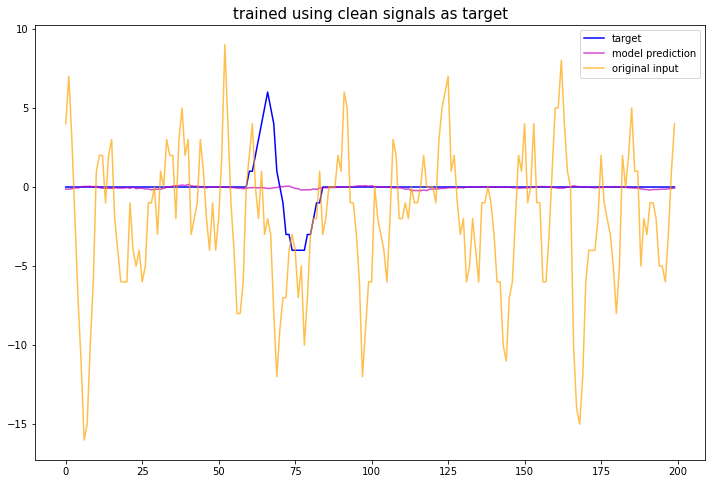

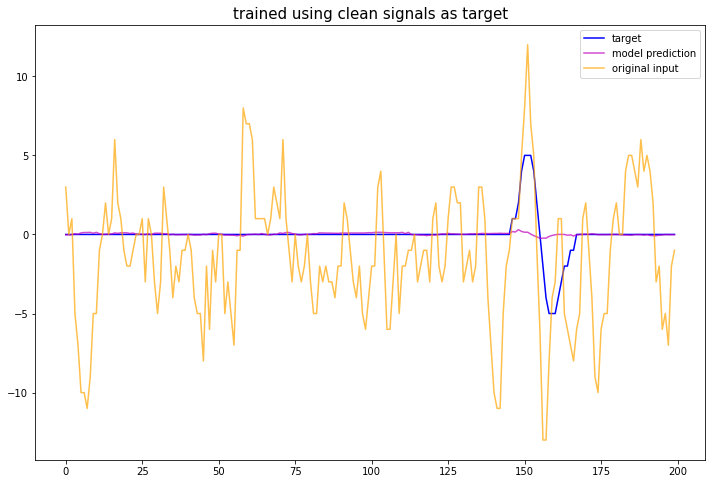

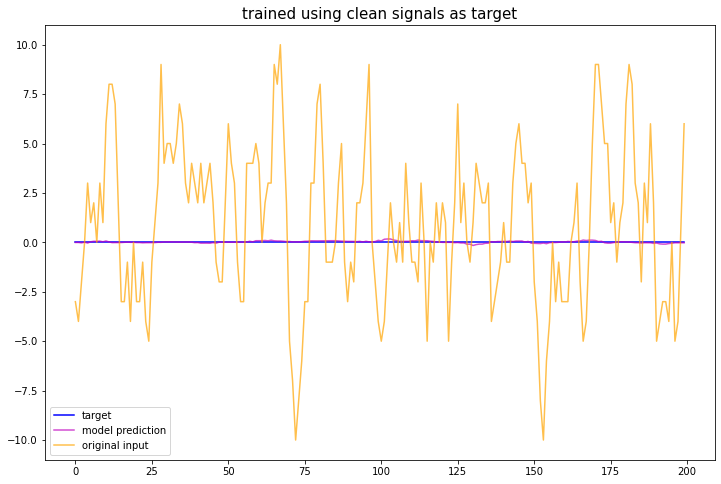

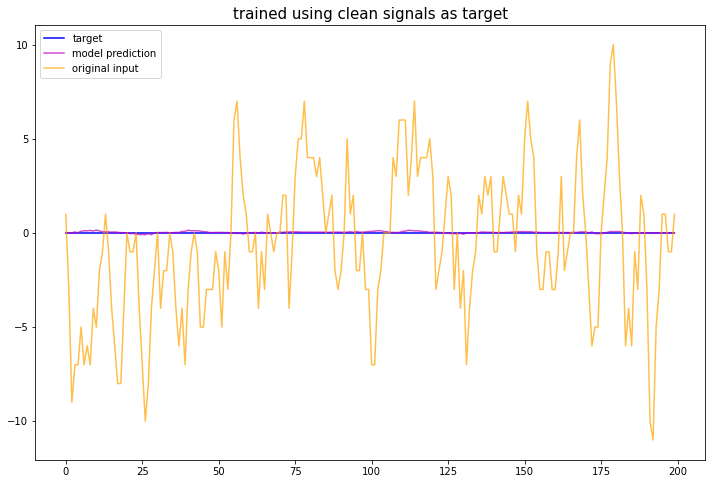

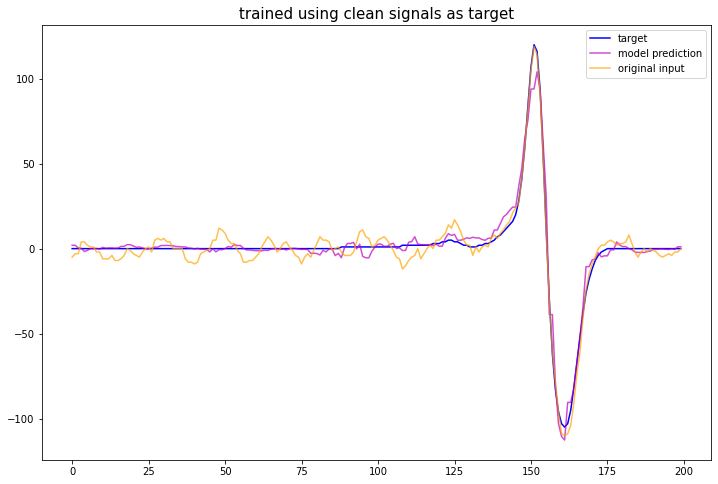

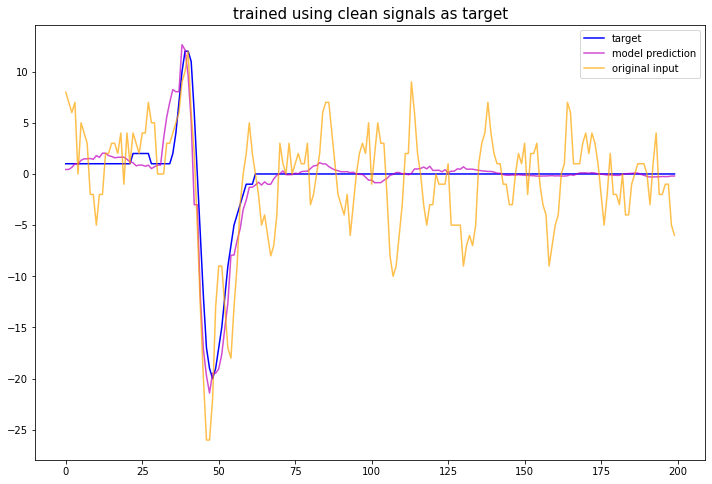

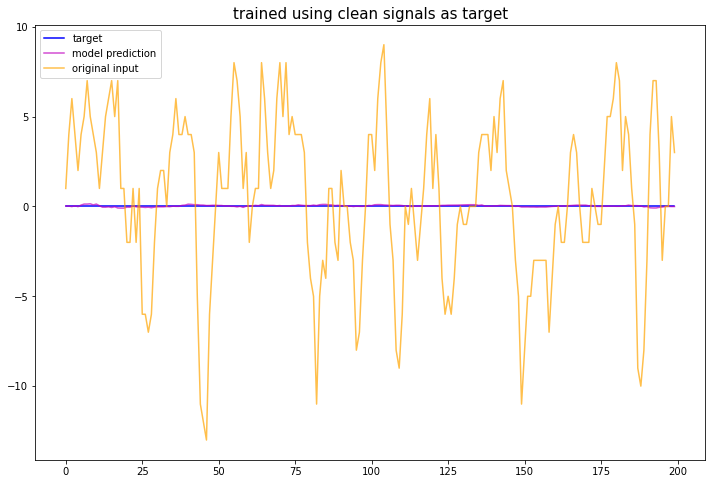

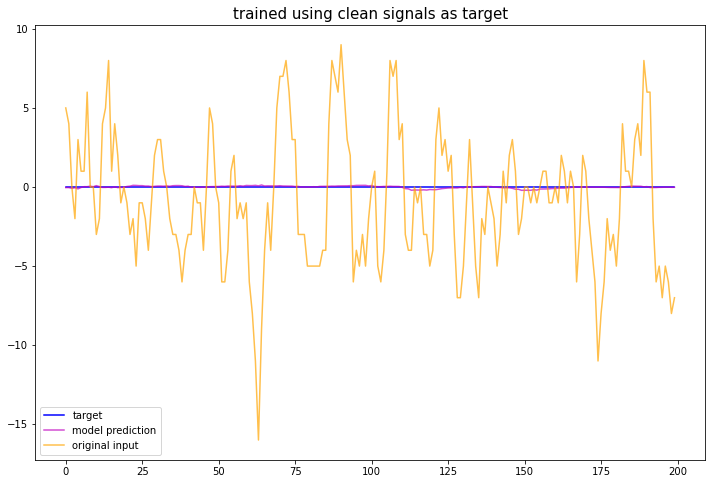

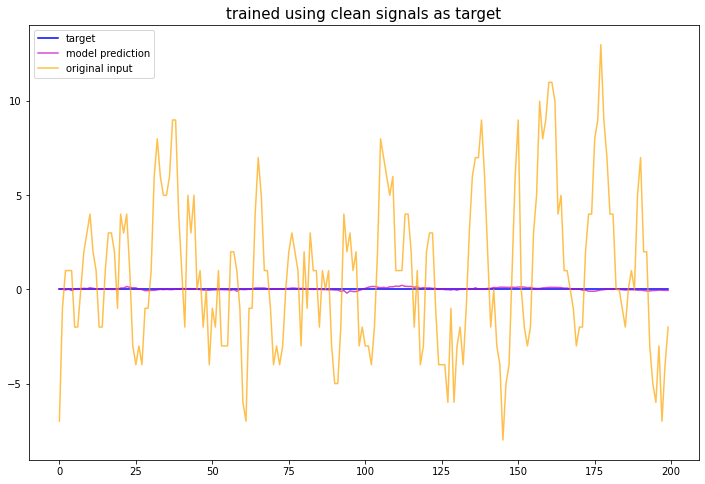

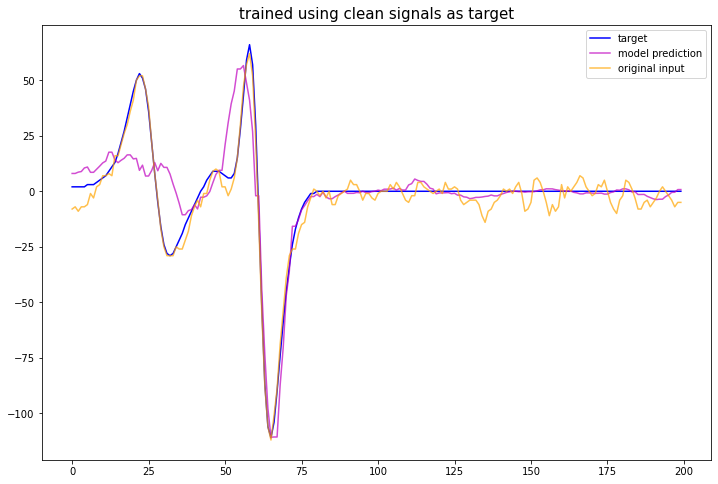

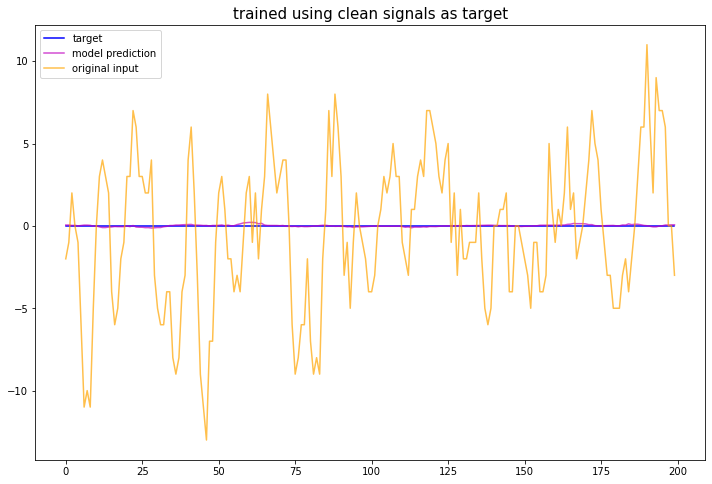

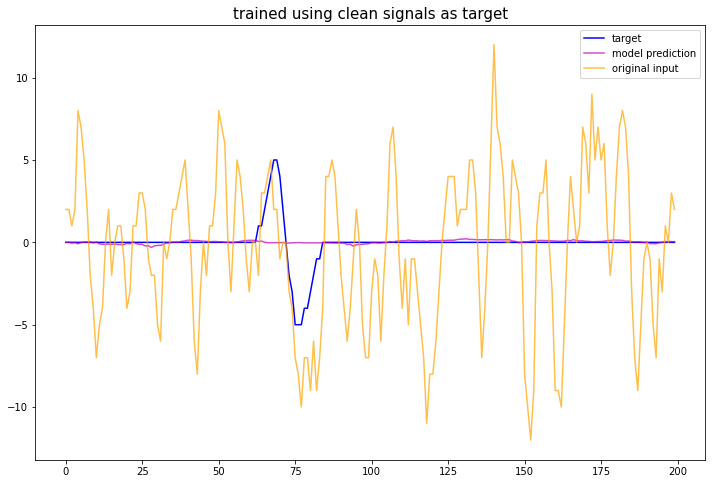

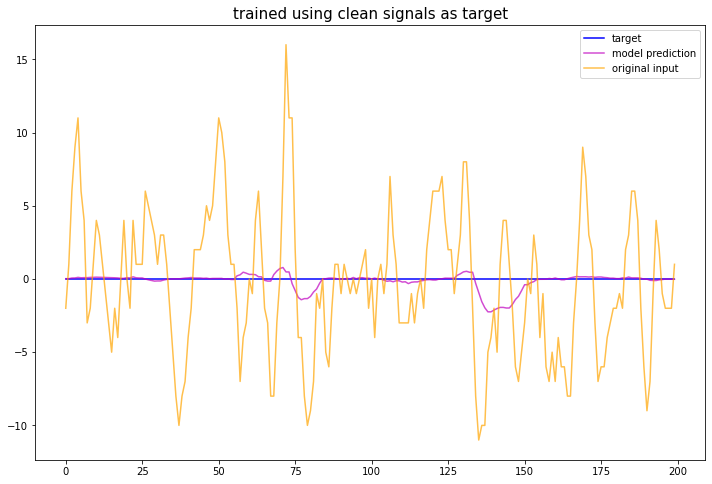

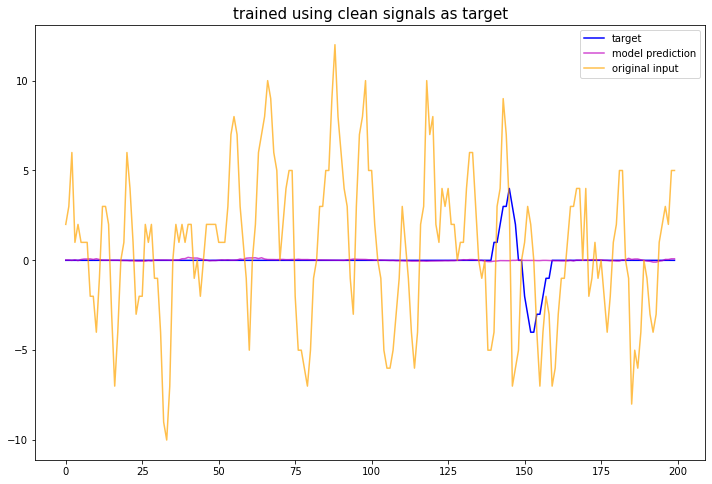

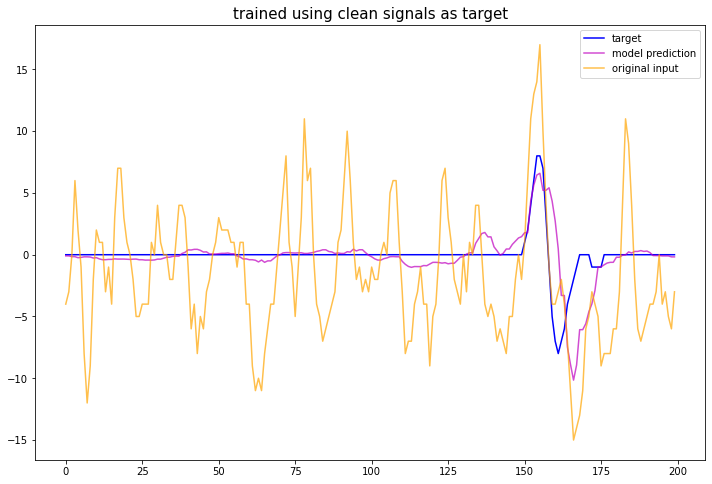

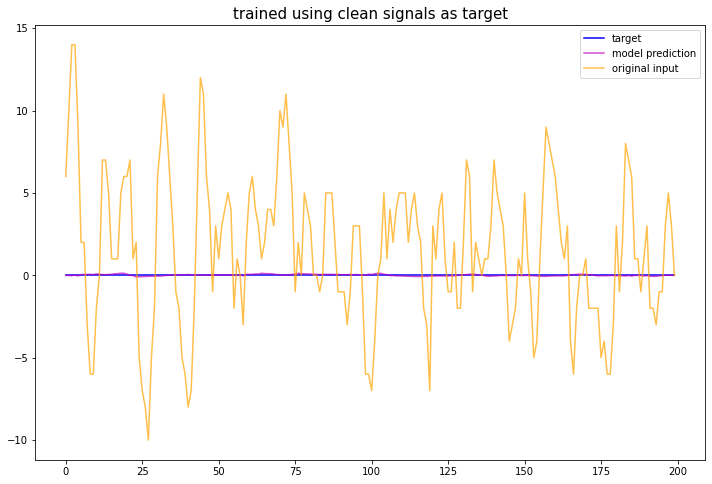

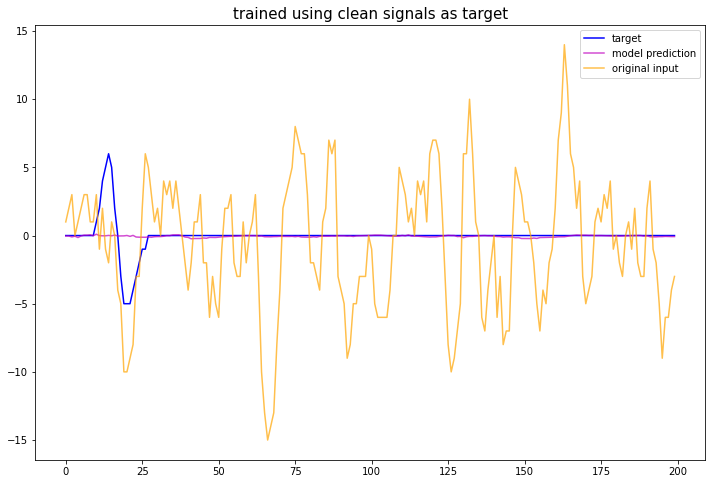

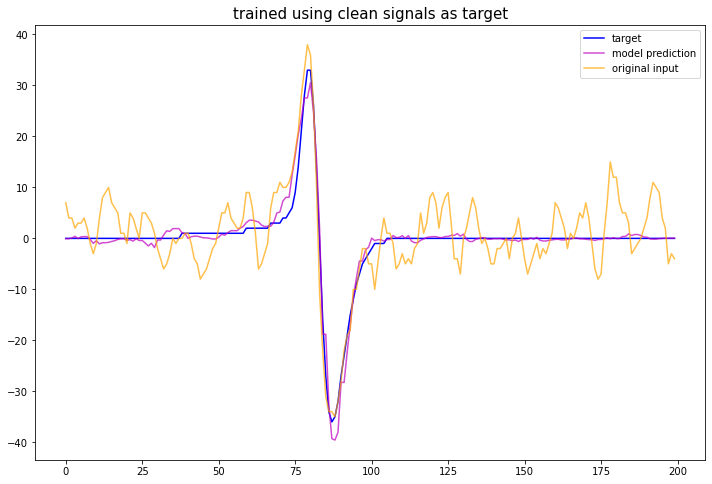

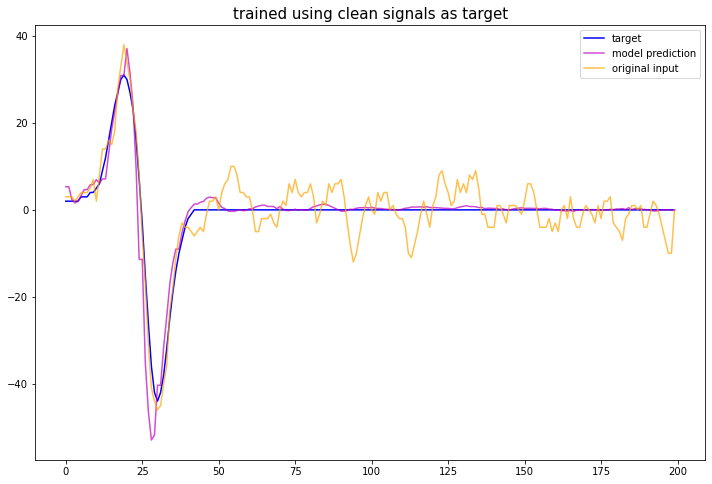

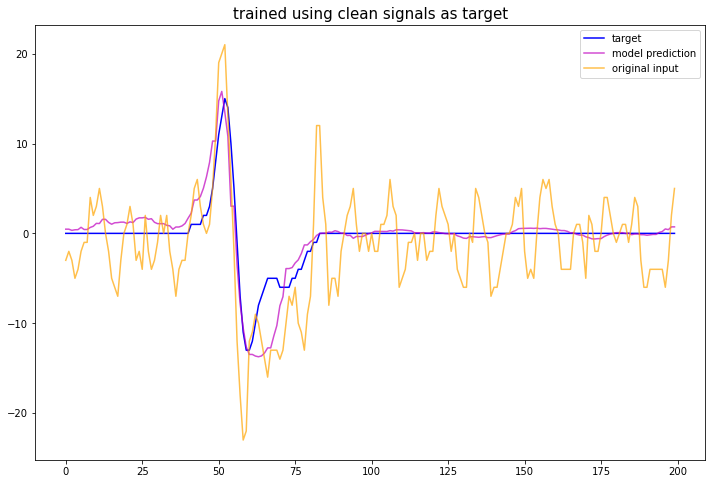

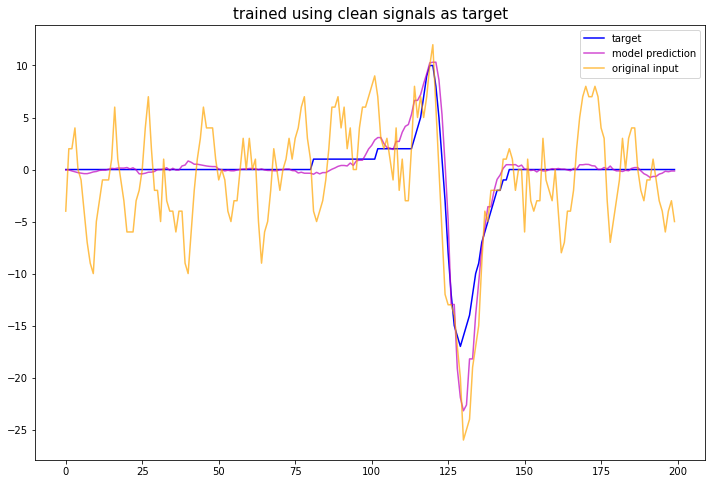

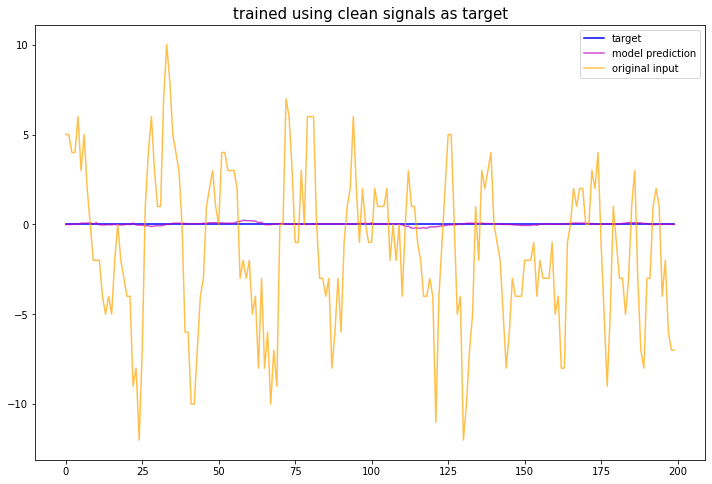

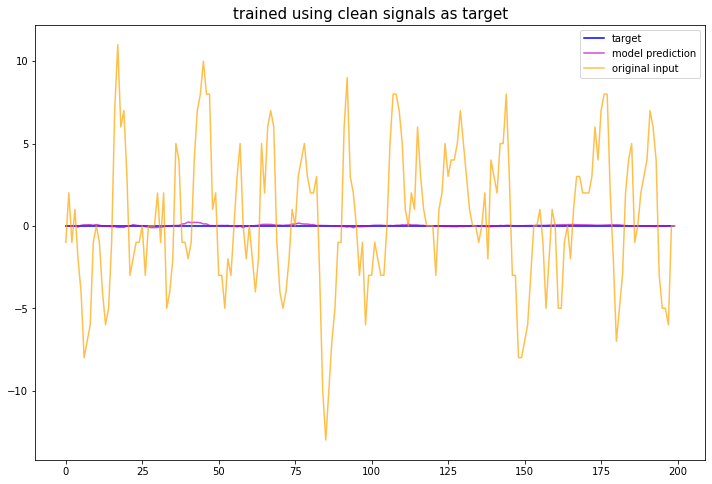

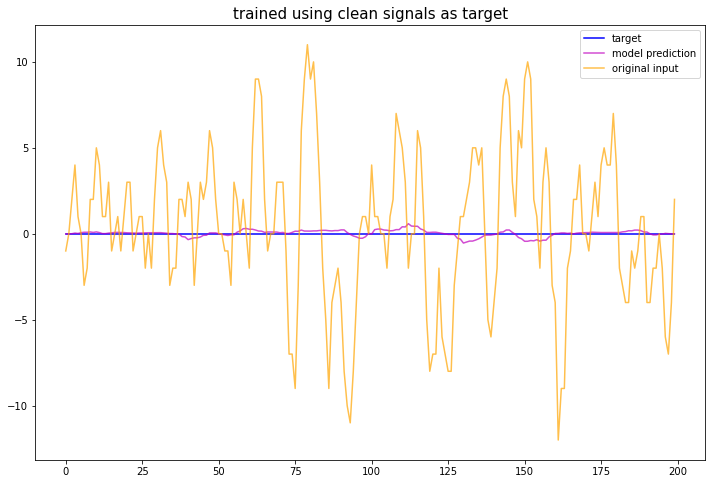

In [22]:
for idx in range(100):
    fig, (ax1) = plt.subplots(figsize=(12, 8), facecolor='white')
    ax1.plot(y_test[idx],color='blue', label='target')
    ax1.plot(y[idx],color='m',alpha=0.7, label='model prediction')
    ax1.plot(x_test[idx], color='orange',alpha=0.7, label = 'original input')
    ax1.set_title("trained using clean signals as target", fontsize=15)
    ax1.legend()

    plt.show()